In [1]:
path = "infData/"

In [2]:
import os
population_path = "population-pyramid-2019/"
files = next(os.walk(path + population_path))[2]

In [3]:
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
import statsmodels.tsa.api as smt

In [4]:
from sklearn.linear_model import LinearRegression
import datetime
from scipy.stats import shapiro
from scipy import stats
from scipy.stats.stats import pearsonr

import pandas as pd
import numpy as np
import plotly.graph_objects as go
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

In [5]:
rus_df = pd.read_csv(path + '/covid19-russia-regions-cases/covid19-russia-cases.csv')
rus_info_df = pd.read_csv(path + '/covid19-russia-regions-cases/regions-info.csv')
rus_df['Date'] = pd.to_datetime(rus_df['Date'], dayfirst=True) 
rus_df['Active'] = rus_df['Confirmed'] - rus_df['Deaths'] - rus_df['Recovered']
rus_df['Death_rate'] = rus_df['Deaths'] / rus_df['Confirmed'] * 100
rus_df['Recovered_rate'] = rus_df['Recovered'] / rus_df['Confirmed'] * 100
rus_df = rus_df[rus_df['Region/City'] != 'Diamond Princess']
cases = ["Confirmed", "Deaths", "Recovered", "Active"]
right = rus_info_df[['Region_ID', 'Population']]
rus_df = rus_df.merge(right, left_on='Region_ID', right_on='Region_ID', how='left')
rus_df['Conf_p100k'] = rus_df.Confirmed / (rus_df.Population / 100000)
rus_df = rus_df.drop('Population', axis=1)
rus_latest = rus_df.groupby('Region/City').apply(lambda df: df.loc[df['Date'].idxmax()])
rus_latest = rus_latest.sort_values(by='Confirmed', ascending=False).reset_index(drop=True)
rus_latest = rus_latest[['Region/City'] + cases + ['Death_rate', 'Conf_p100k', "Recovered_rate", "Region_ID"]]
rus_latest = rus_latest.astype({"Confirmed": int, "Deaths": int, "Recovered": int, "Active": int})
reg_vent = pd.read_csv(path + "/covid19-russia-regions-cases/regions-ventilators.csv")
reg_vent = reg_vent.fillna(value={'Region_ID': 0.0, "ECMO_idx": -1, "Vent_idx": -1})
temp = rus_df.groupby('Date')['Recovered', 'Deaths', 'Active'].sum().reset_index()
temp = temp.drop([0, 1, 2])
len(temp)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



53

In [6]:
def plotseird(t, **kwargs):
    count_days = None
    fig = go.Figure()
    color = {"Susceptible": '#636EFA', "Exposed": "#FF6692", "Infected":"#D62728", "Recovered": "#2CA02C"}
    if kwargs.get("SIER") is not None:
        for k, v in kwargs["SIER"].items():
            fig.add_trace(go.Scatter(x=t, y=v,
                            mode='lines',
                            name=k + " SEIR",
                            line=dict(color=color[k], width=3)))
    if kwargs.get("real_data") is not None:
        for k, v in kwargs["real_data"].items():
            fig.add_trace(go.Scatter(x=t, y=v,
                            mode='lines',
                            name=k + " real",
                            line=dict(color=color[k], width=4,
                                      dash='dash')))
            count_days = len(v)
    if kwargs.get("SIER_optimize") is not None:
        for k, v in kwargs["SIER_optimize"].items():
                fig.add_trace(go.Scatter(x=t, y=v,
                                mode='lines',
                                name=k + " optimize",
                                line=dict(color=color[k], width=4,
                                          dash='dot')))
    if kwargs.get("Regressor") is not None:
        for k, v in kwargs["Regressor"].items():
            if count_days is not None:
                s = count_days - 1
            else:
                s = len(v)
            fig.add_trace(go.Scatter(x=t[:s], y=v[:s],
                            mode='lines',
                            name=k + " reg",
                            line=dict(color=color[k], width=4,
                                      dash='dot')))
        if count_days is not None:
            for k, v in kwargs["Regressor"].items():
                    fig.add_trace(go.Scatter(x=t[s:], y=v[s:],
                                    mode='lines',
                                    name=k + " predict",
                                    line=dict(color="#636EFA", width=4,
                                              dash='dot')))
    fig.update_layout(title=kwargs["titel"],
                   xaxis_title='Days',
                   yaxis_title='Number of people')
    fig.show()


In [7]:
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import LinearRegression
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

In [8]:
t = np.linspace(0, 56, 56)

In [81]:
def inv_boxcox_transform(x, lmbda):
    if lmbda != 0:
        return (x * lmbda + 1) ** (1/lmbda)
    else:
        return np.exp(x)


def grate_a_b(x, y):
    x = np.array(x)
    y = np.array(y)
    beta = np.mean(np.multiply(x - np.mean(x, axis=0), np.stack(([y] * x.shape[1]), axis=1)), axis=0)/ np.mean(((x - np.mean(x, axis =0)) ** 2), axis =0)
    alph = y.mean() - np.dot(beta, np.mean(x, axis =0).T)
    return alph, beta

def homoscedasticity_test(model):
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    
    y_test = pd.DataFrame(sms.het_white(resids, model.model.exog),
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])
    print('Тест Уайта')
    print(y_test)
    print("-----------------------------------------------------------")
    print('Тест Бройша - Пагана')
    print(bp_test)
    print("===========================================================")

def linearity_test(model, y):
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
        
def normality_of_residuals_test(model):
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Тест Харке — Бера: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Тест Шапиро – Уилка: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Критерий согласия Колмогорова: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Критерий Андерсона — Дарлинга: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')

def check_corr(x, resid):
    for i in range(len(x[0])):
        x_ = np.array(x)[:, i]
        corr_test = pearsonr(x_, resid)
        print(f'x{i}: correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')

def predict(y, model, num_day, lmbda, inf_rec, name):
    predict_ = model.predict(sm.add_constant(np.arange(num_day).reshape(-1,1)))
    plotseird(np.arange(num_day),
         real_data={
                   inf_rec:y},
         Regressor={
              inf_rec:predict_,},
         titel="Regressor predict" + " " + name)
    
    predict_ = [inv_boxcox_transform(i, lmbda) for i in predict_]
    y = [inv_boxcox_transform(i, lmbda) for i in y]
    plotseird(np.arange(num_day),
         real_data={inf_rec:y},
         Regressor={
              inf_rec:predict_,},
         titel="Regressor predict")
    return predict_

def gauss_marcov_hip(x, y, inf_rec, lmbda):
    t = np.linspace(0, 56, 57)
    X_constant = sm.add_constant(x)
    lin_reg = sm.OLS(y,X_constant).fit()
    print(lin_reg.summary())
    print("===========================================================")
    print("===========================================================")
    print("Проверка несистематичности ошибки")
    print("Среднее значение ошибки =", lin_reg.resid.mean())
    a, b = grate_a_b(x, y)
    print("Оценки для a = %.3f и b =" % a, b)
    print("===========================================================")
    linearity_test(lin_reg, y)
    print("===========================================================")
    print("Проверка гомоскедастичности")
    homoscedasticity_test(lin_reg)
    print("===========================================================")
    print("Проверка автокорреляции")
    print("Тест Дурбина-Ватсона") ## если значение теста близко к 0, тогда есть положительная корреляция, если к 2-м то кореляции нет, к 4-м то отриц кор. 
    print("Статистика =", sms.durbin_watson(lin_reg.resid))
    print("===========================================================")
    acf = smt.graphics.plot_acf(lin_reg.resid, lags=20 , alpha=0.05)
    acf.show()
    print("===========================================================")
    print("Проверка независимости распределения случайного члена от объясняющей переменной")
    check_corr(x, lin_reg.resid) # в нашем случае нельзя отклонить гим
    print("===========================================================")
    print("===========================================================")
    print("Проверка нормальности остатков")
    normality_of_residuals_test(lin_reg)
    return predict(y, lin_reg, 55, lmbda, inf_rec, "Box-cocx")
    

In [82]:
from scipy.stats import boxcox



# Линейная регрессия с преобразованием таргета

## box-cocx Infected

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     7405.
Date:                Thu, 14 May 2020   Prob (F-statistic):           1.79e-52
Time:                        19:00:57   Log-Likelihood:                -27.787
No. Observations:                  48   AIC:                             59.57
Df Residuals:                      46   BIC:                             63.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0295      0.125      8.214      0.0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



48


48


Lambda box-cocx = 0.09608585342915454


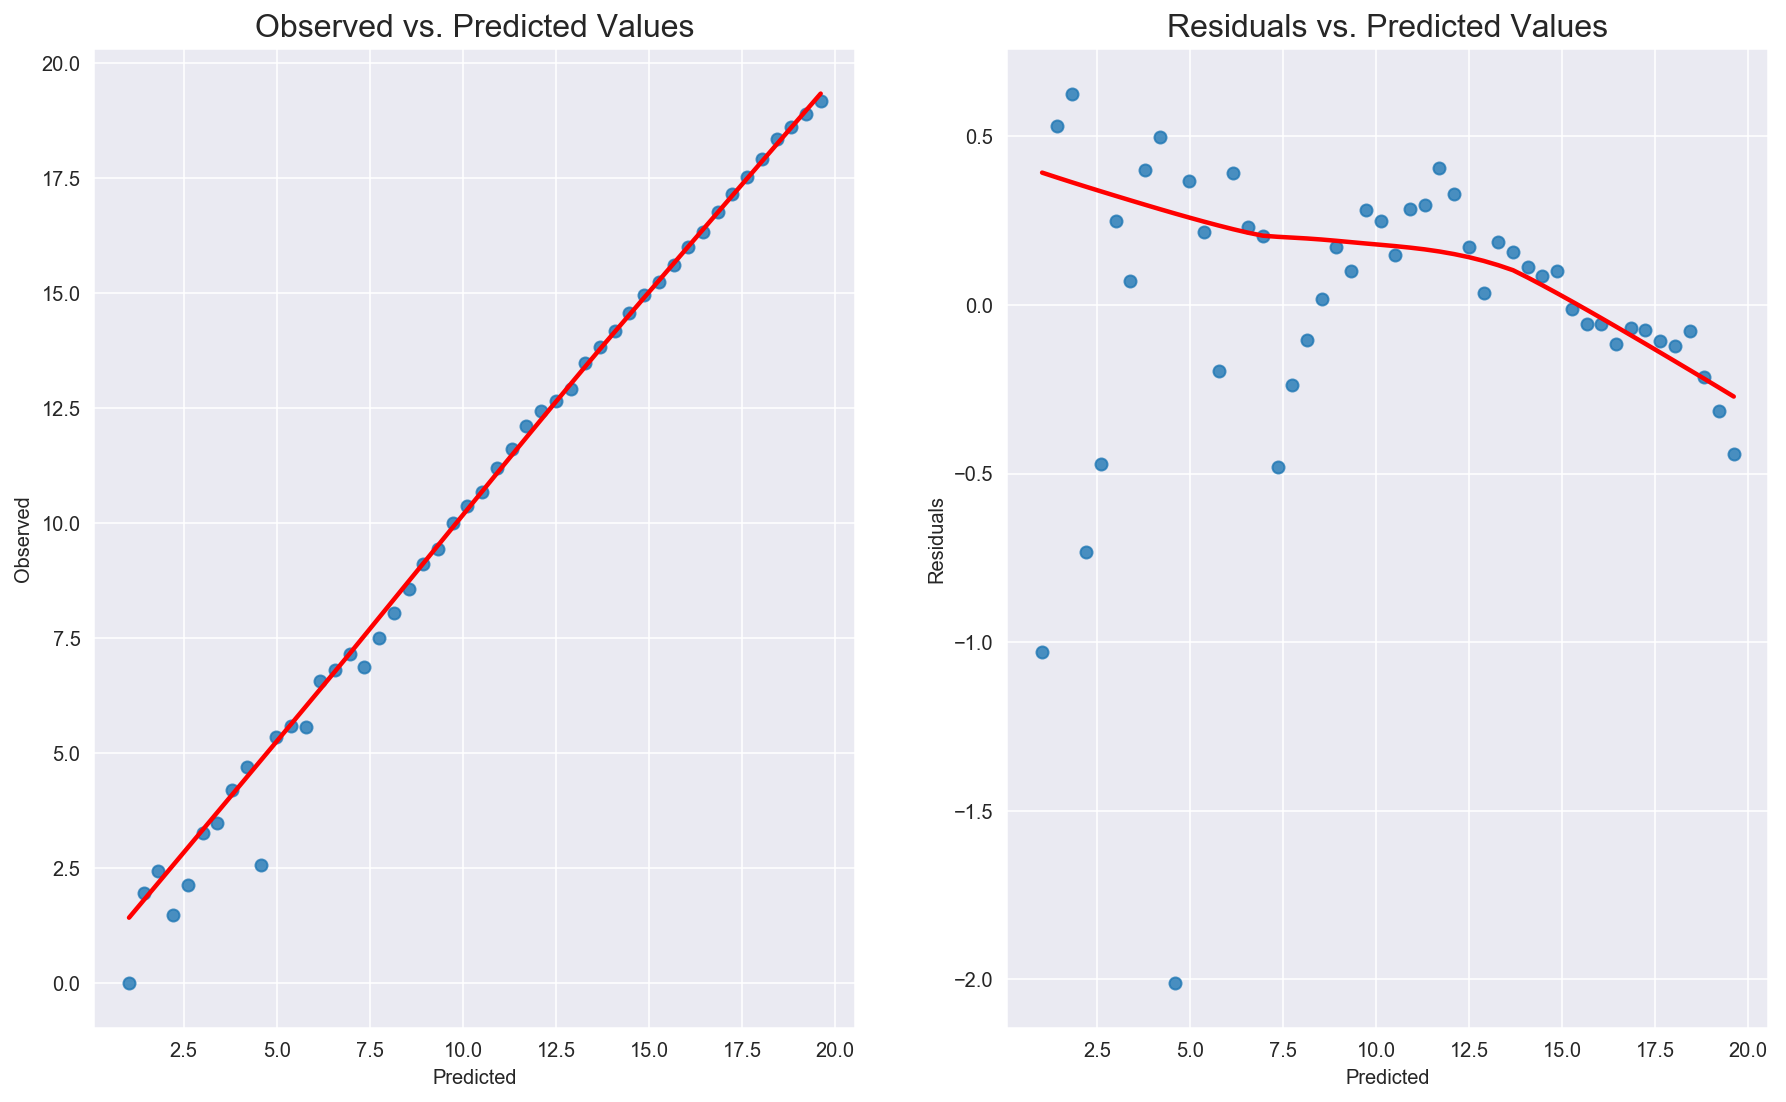

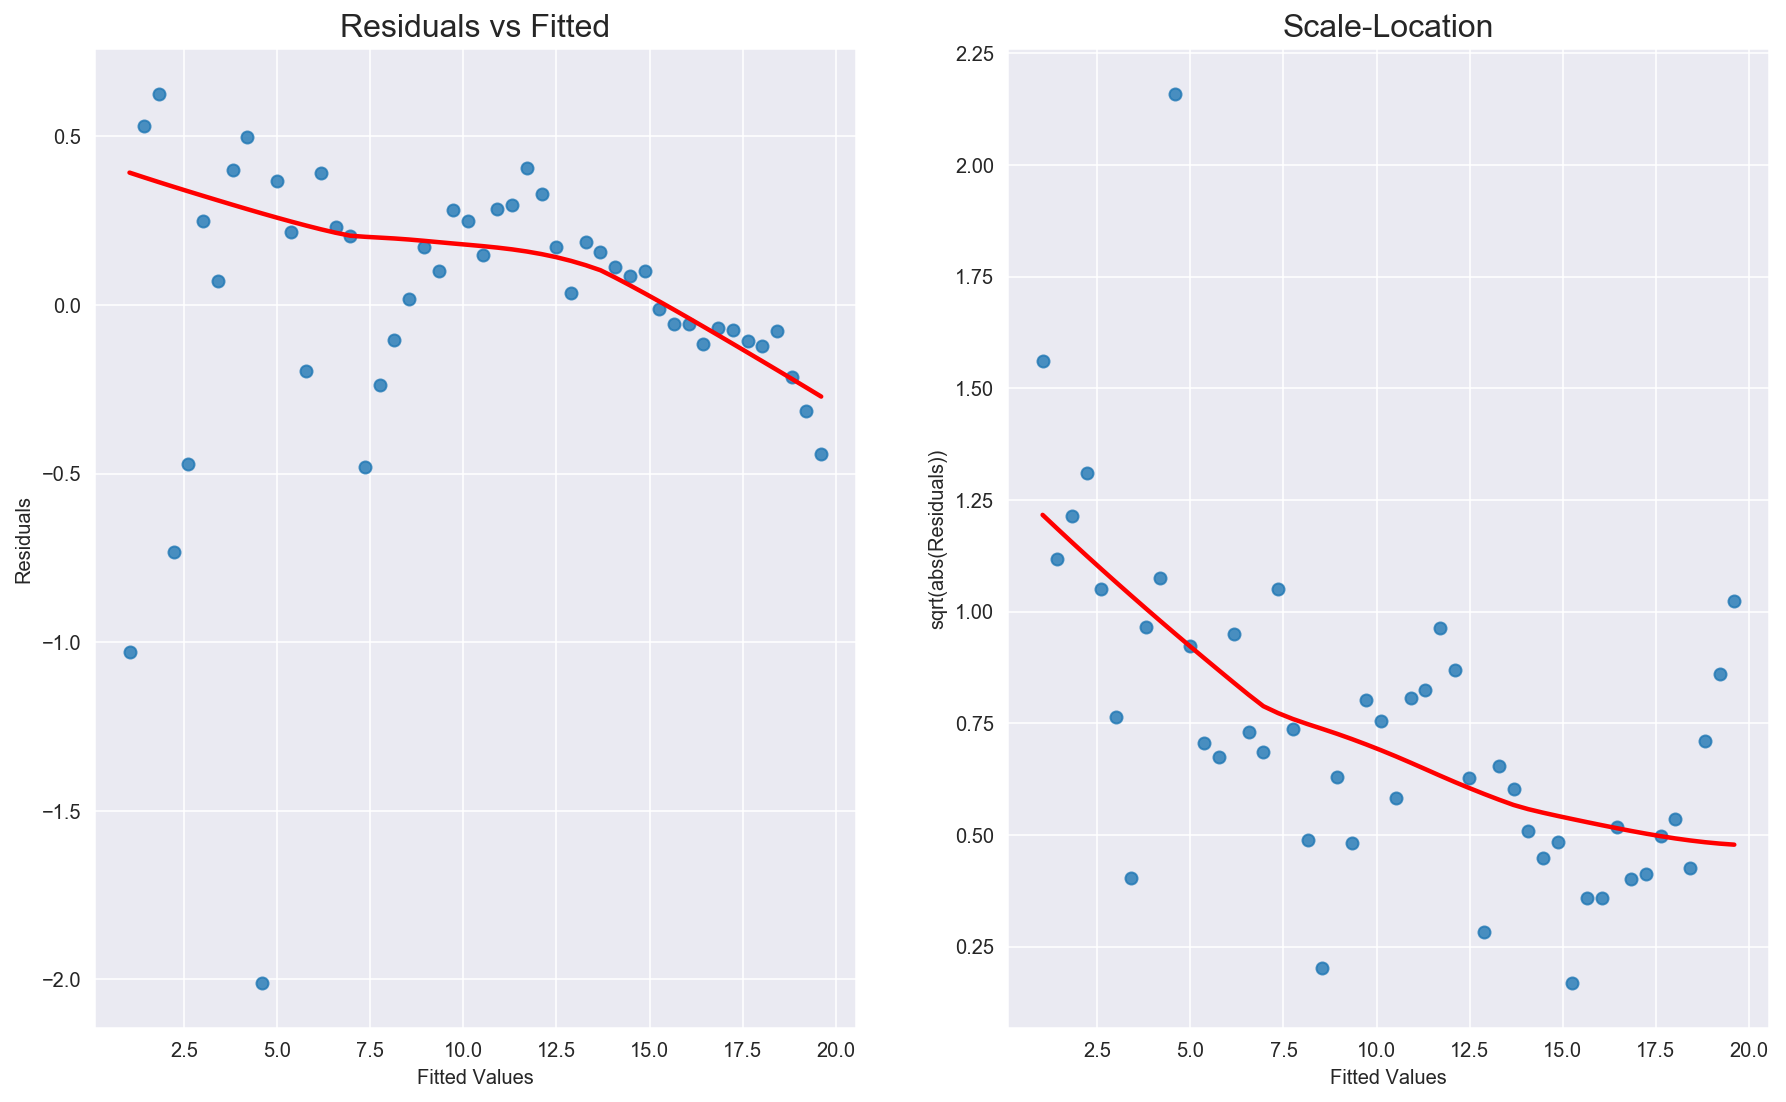

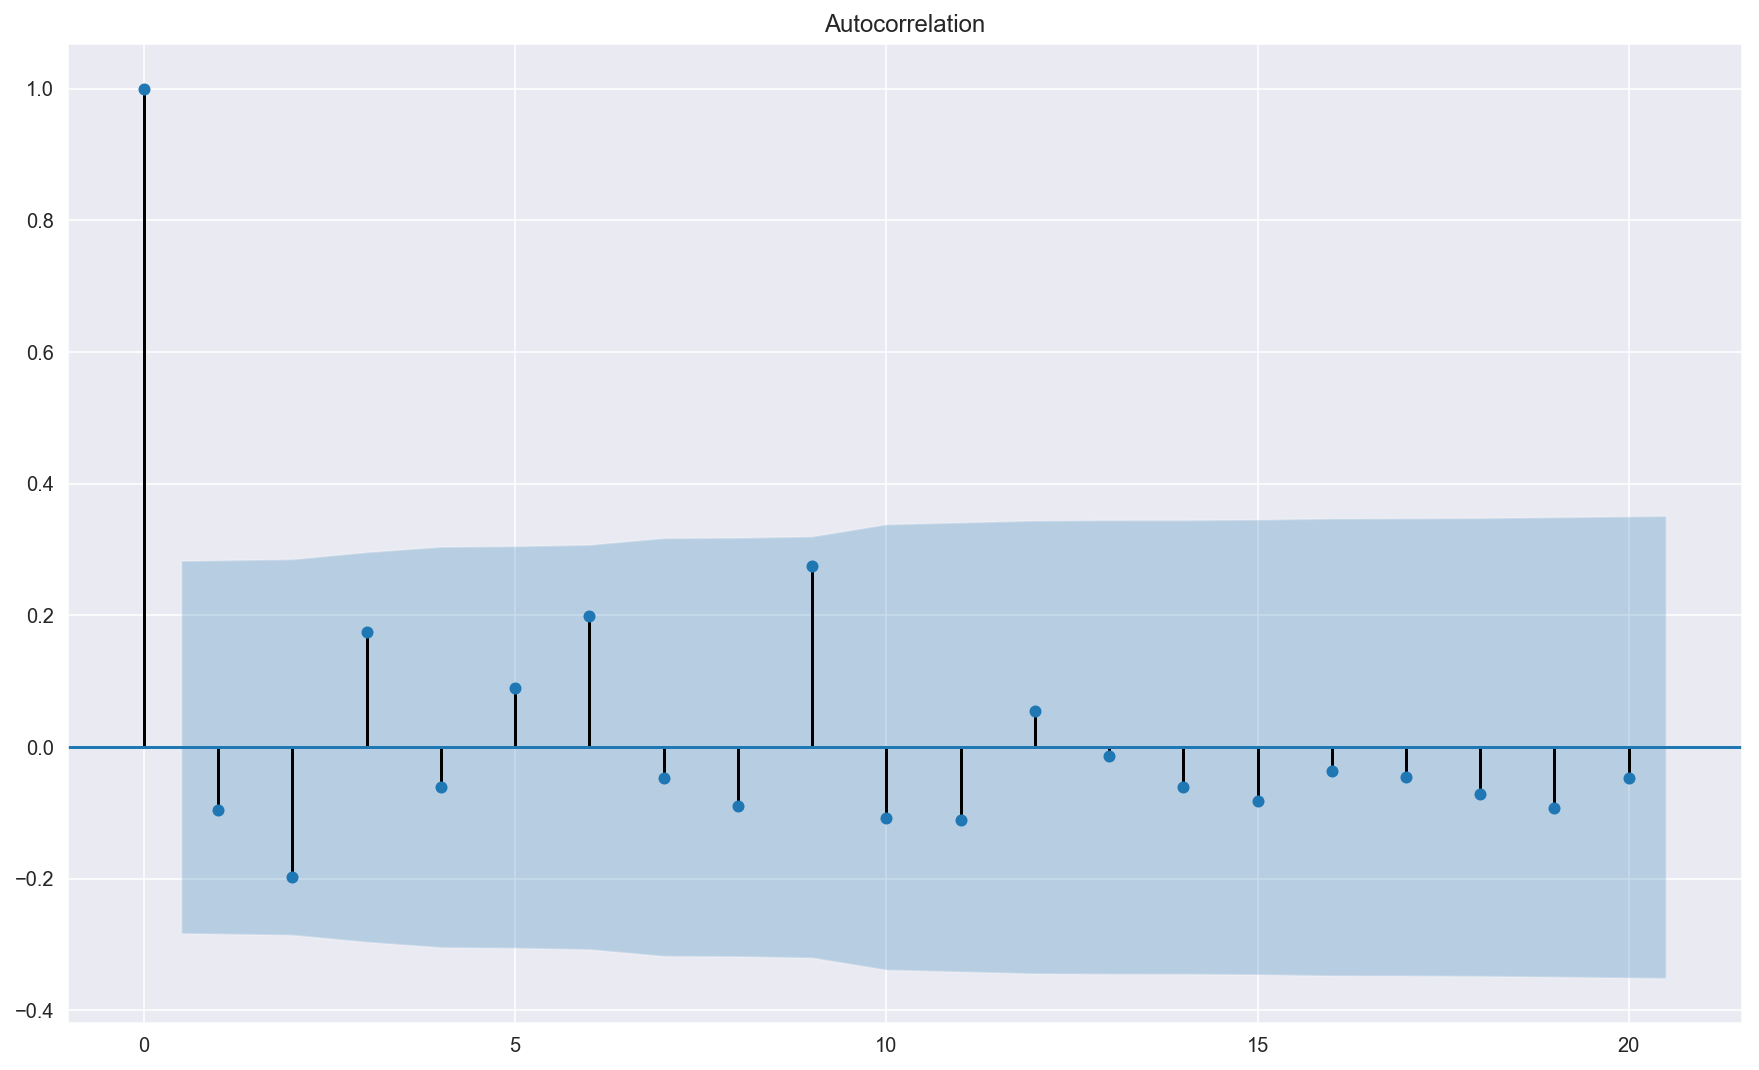

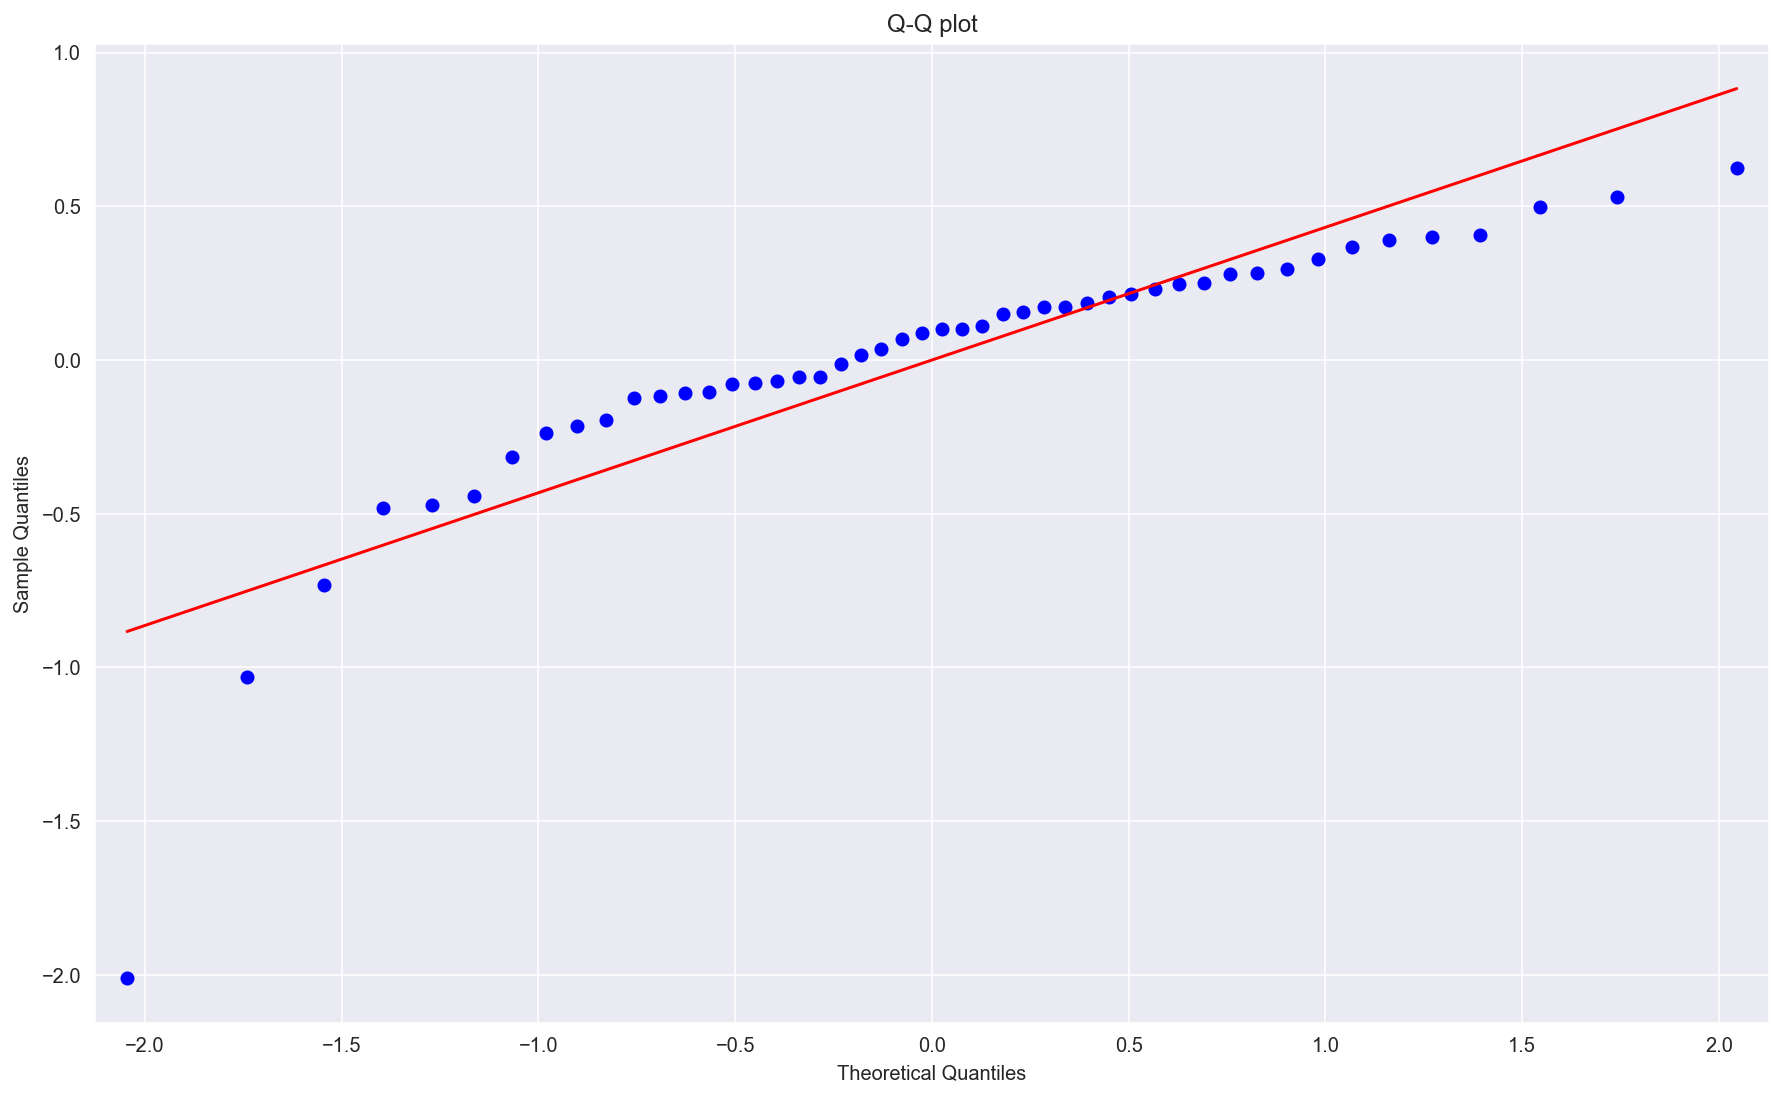

In [138]:
y_boxcox, lmbda = boxcox(temp["Active"].values)
x = [[i] for i, d in enumerate(temp["Date"].dt.weekday)]
y = temp["Active"]
predict_box = gauss_marcov_hip(x[:48], y_boxcox[:48], "Infected", lmbda)
print("Lambda box-cocx =", lmbda)

## Log Infected

                            OLS Regression Results                            
Dep. Variable:                 Active   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1348.
Date:                Thu, 14 May 2020   Prob (F-statistic):           1.01e-35
Time:                        18:30:58   Log-Likelihood:                -38.164
No. Observations:                  48   AIC:                             80.33
Df Residuals:                      46   BIC:                             84.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8519      0.156     11.903      0.0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



48


48


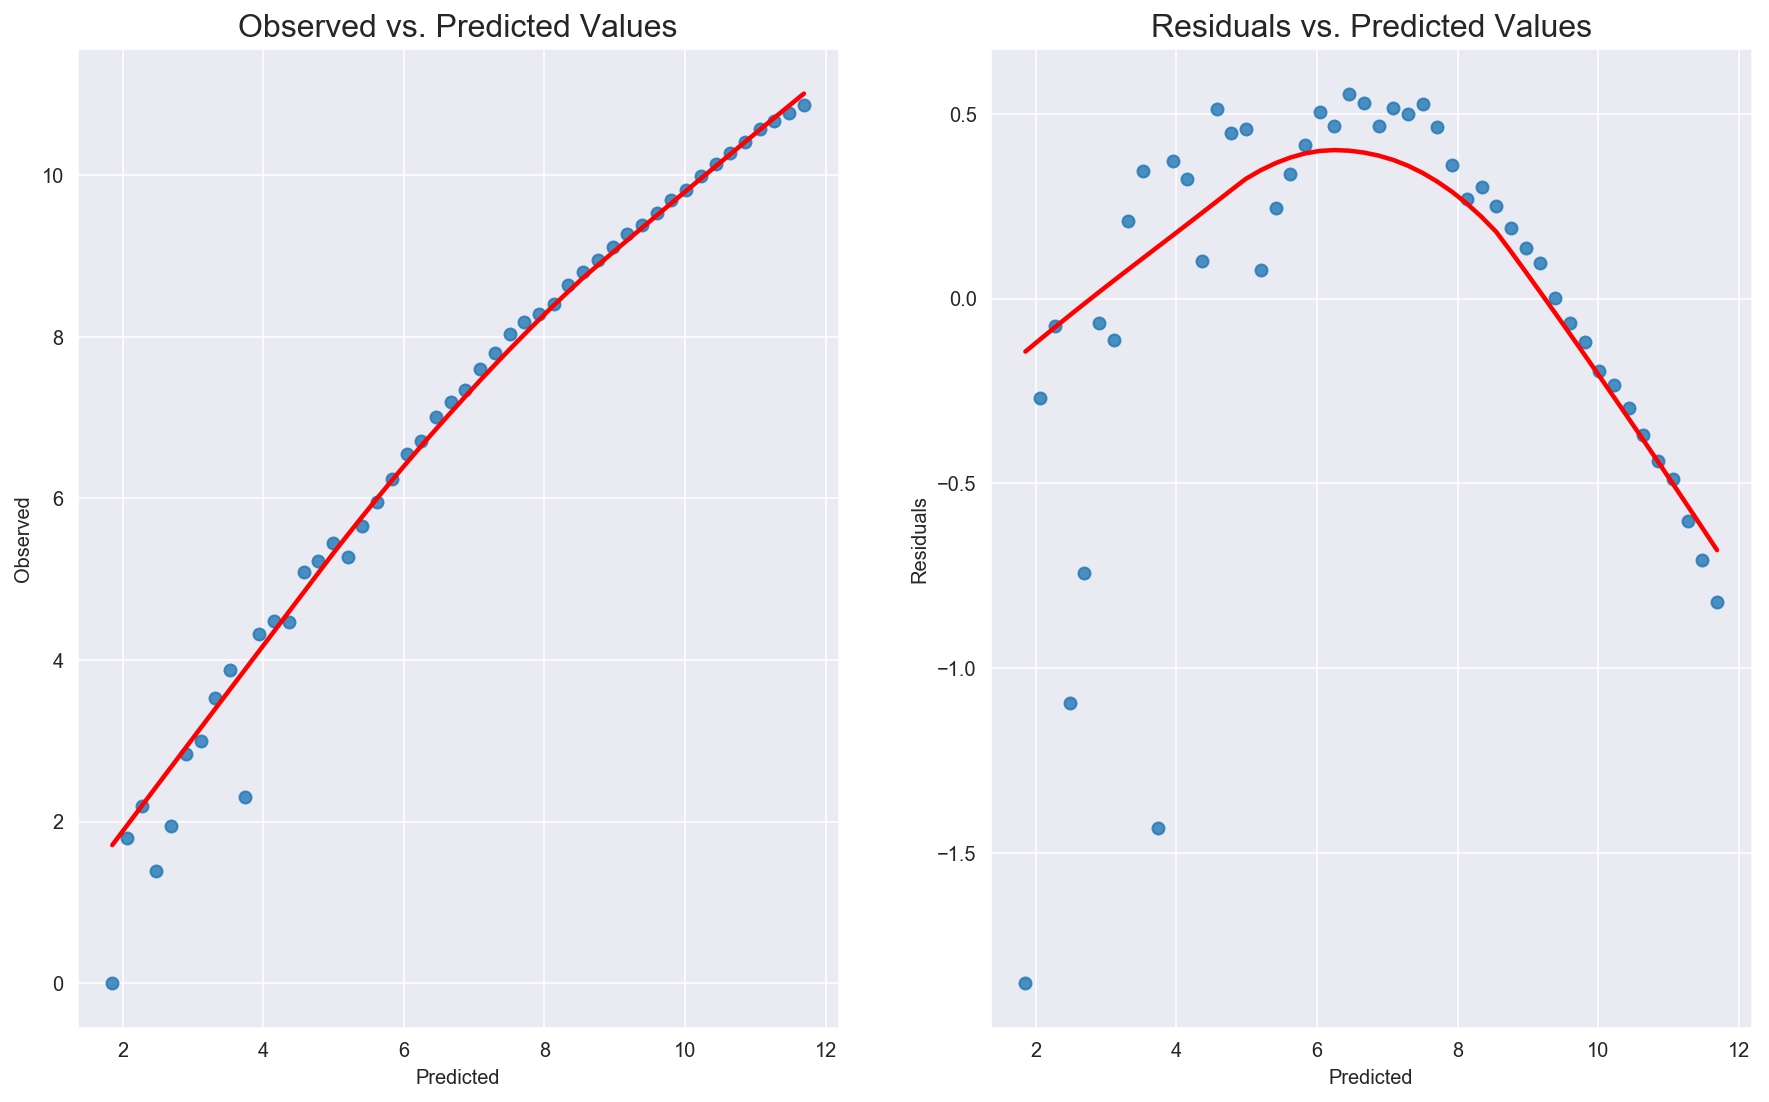

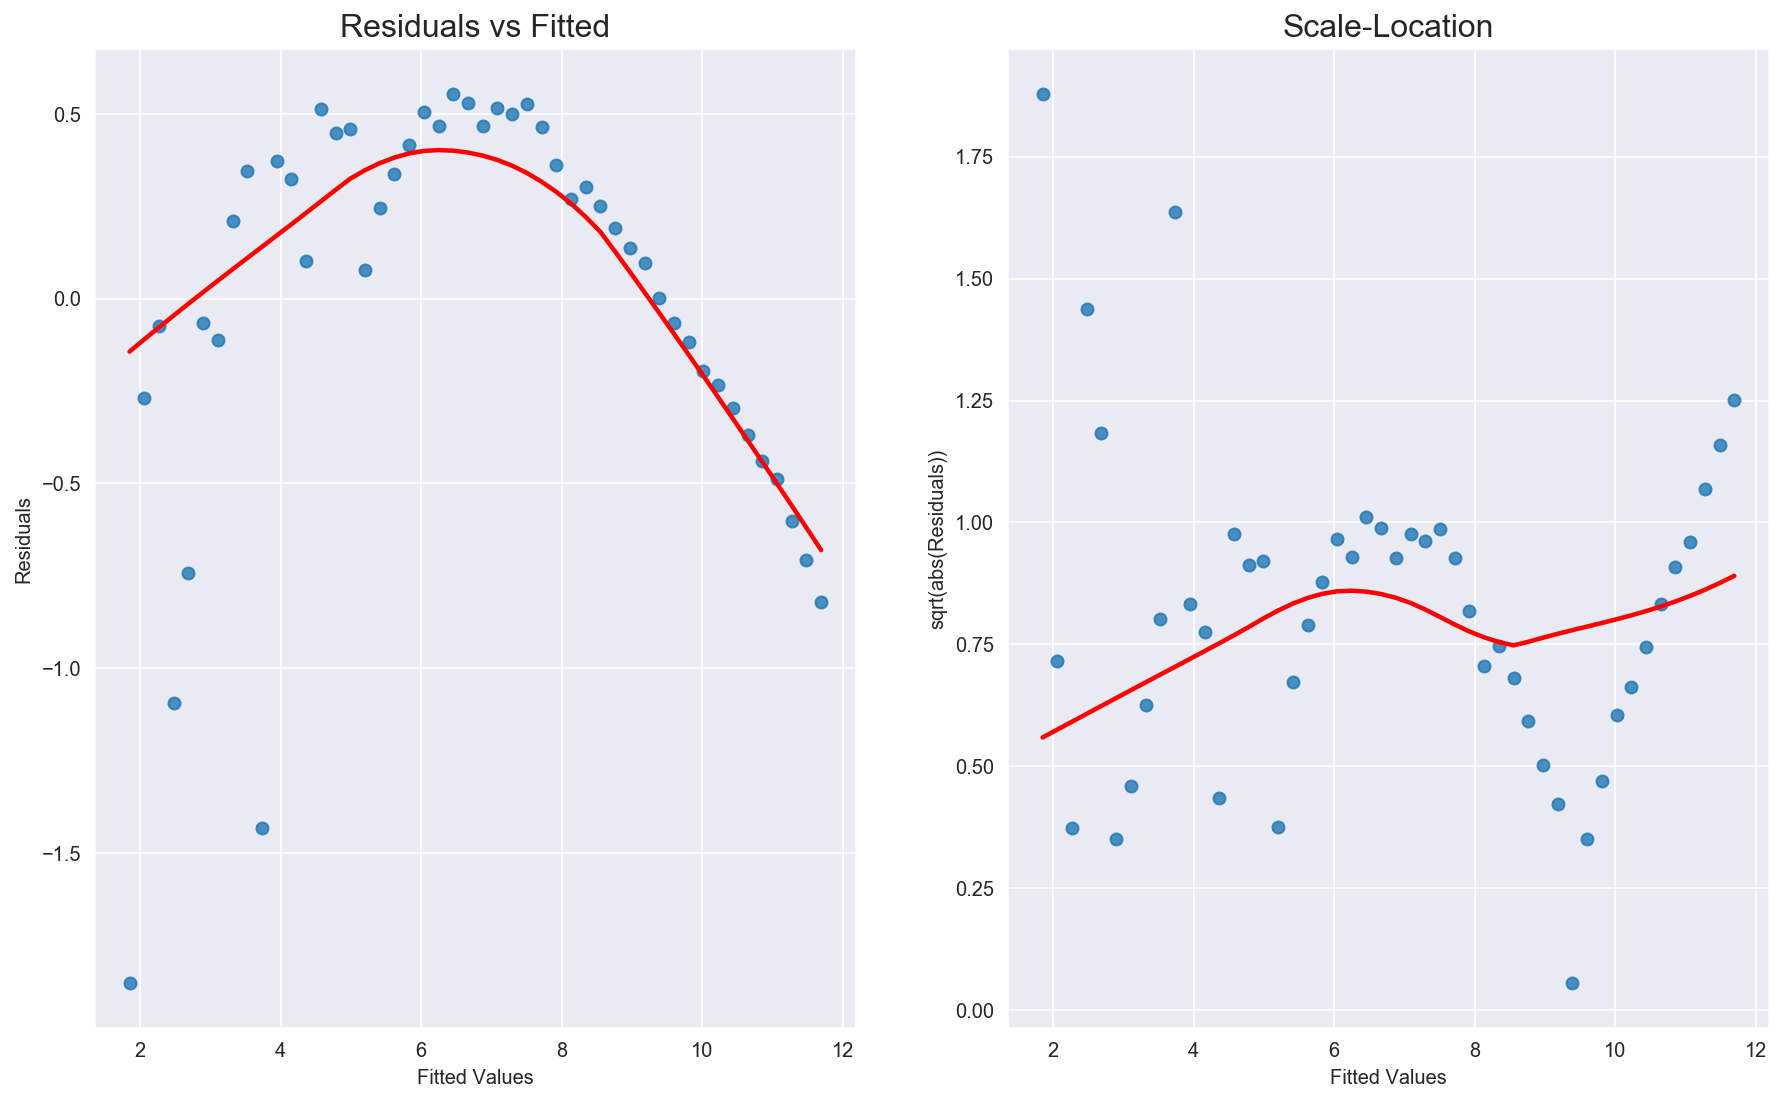

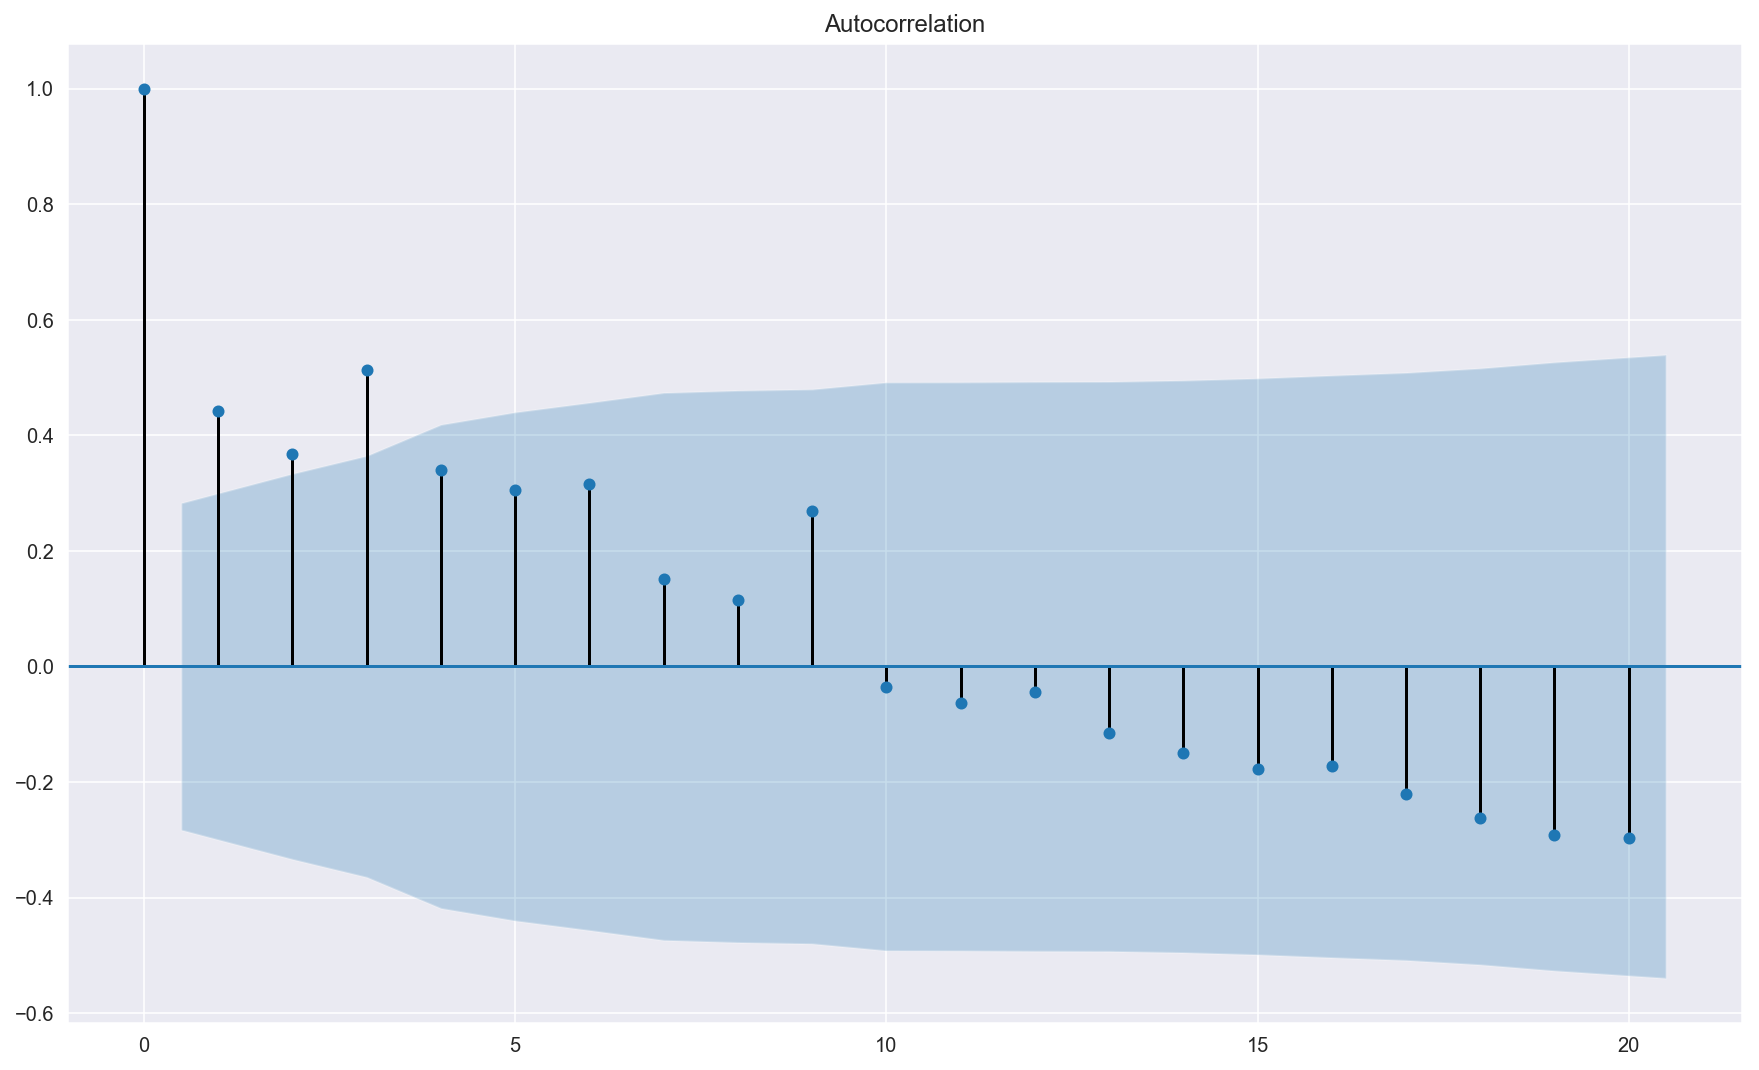

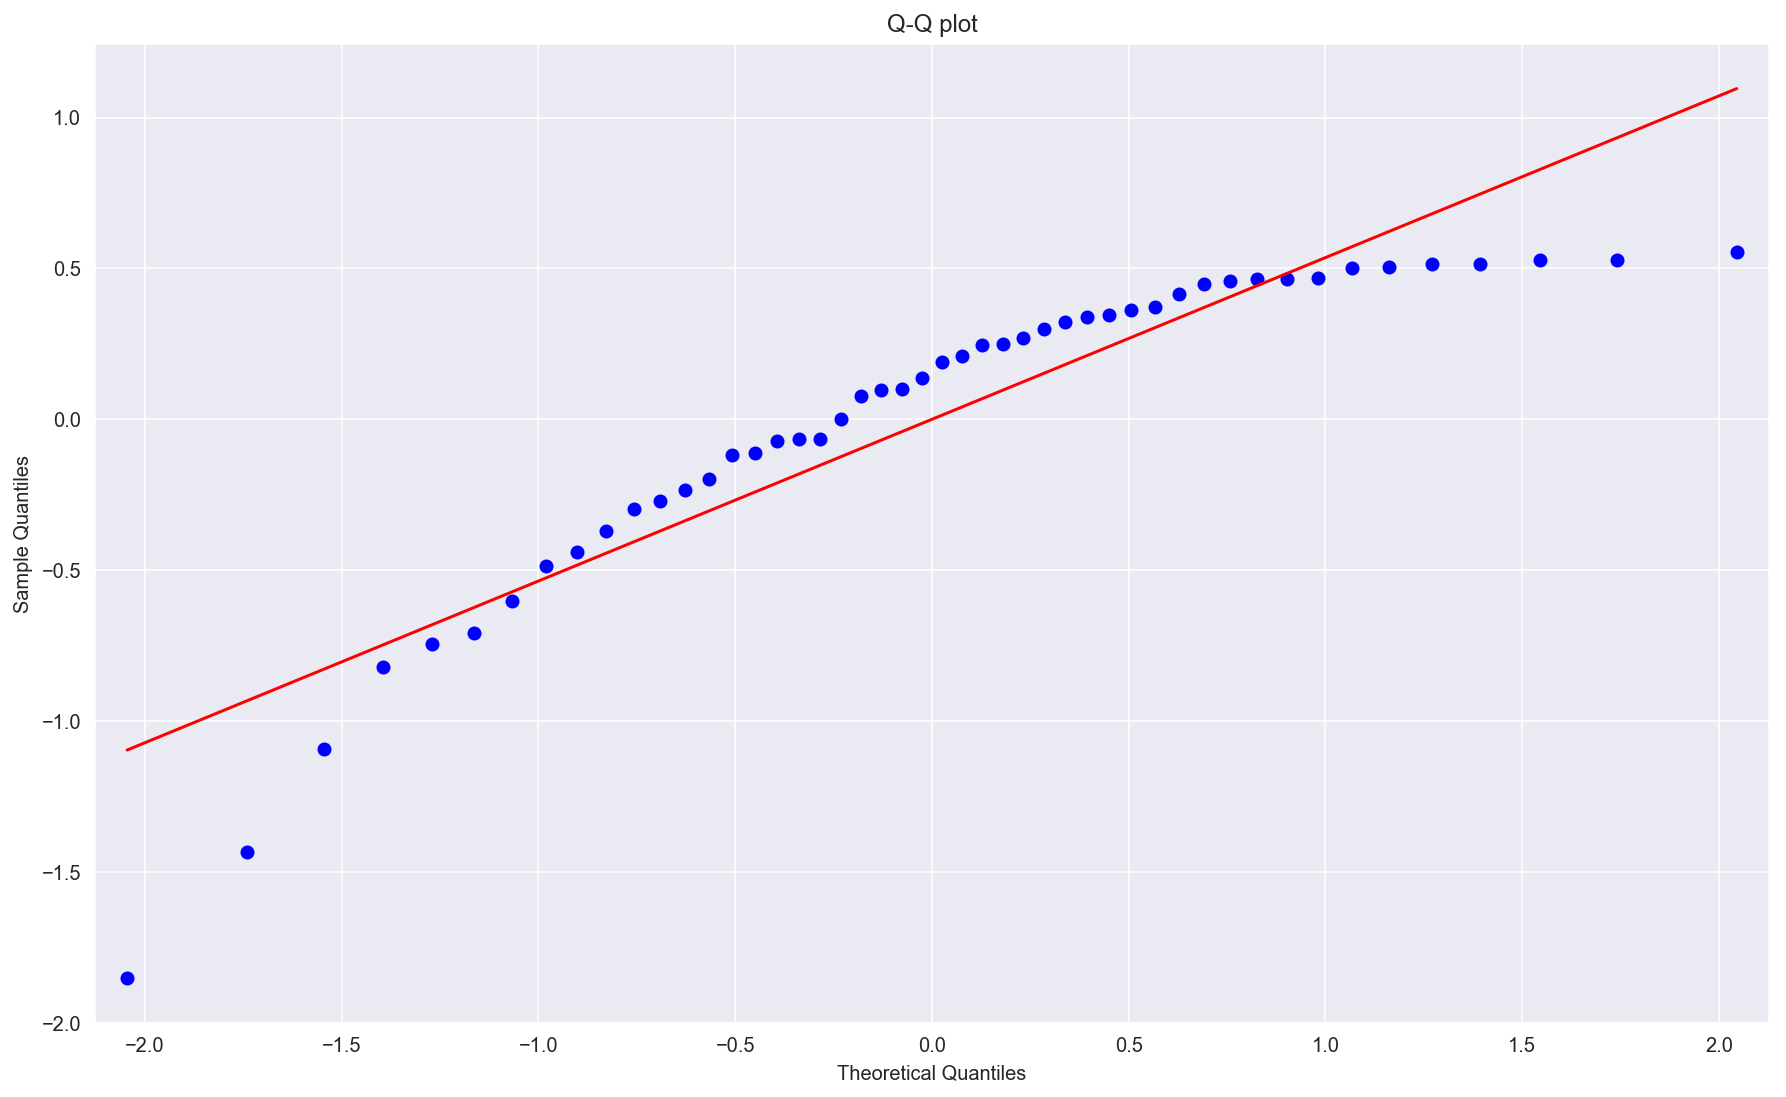

In [86]:
y_boxcox, lmbda = boxcox(temp["Active"].values)
x = [[i] for i, d in enumerate(temp["Date"].dt.weekday)]
y = temp["Active"]
predict_log = gauss_marcov_hip(x[:48], np.log(y)[:48], "Infected", 0)

## Log Recovered

                            OLS Regression Results                            
Dep. Variable:              Recovered   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     2642.
Date:                Thu, 14 May 2020   Prob (F-statistic):           2.75e-42
Time:                        18:33:07   Log-Likelihood:                -19.555
No. Observations:                  48   AIC:                             43.11
Df Residuals:                      46   BIC:                             46.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4646      0.106     -4.401      0.0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



48


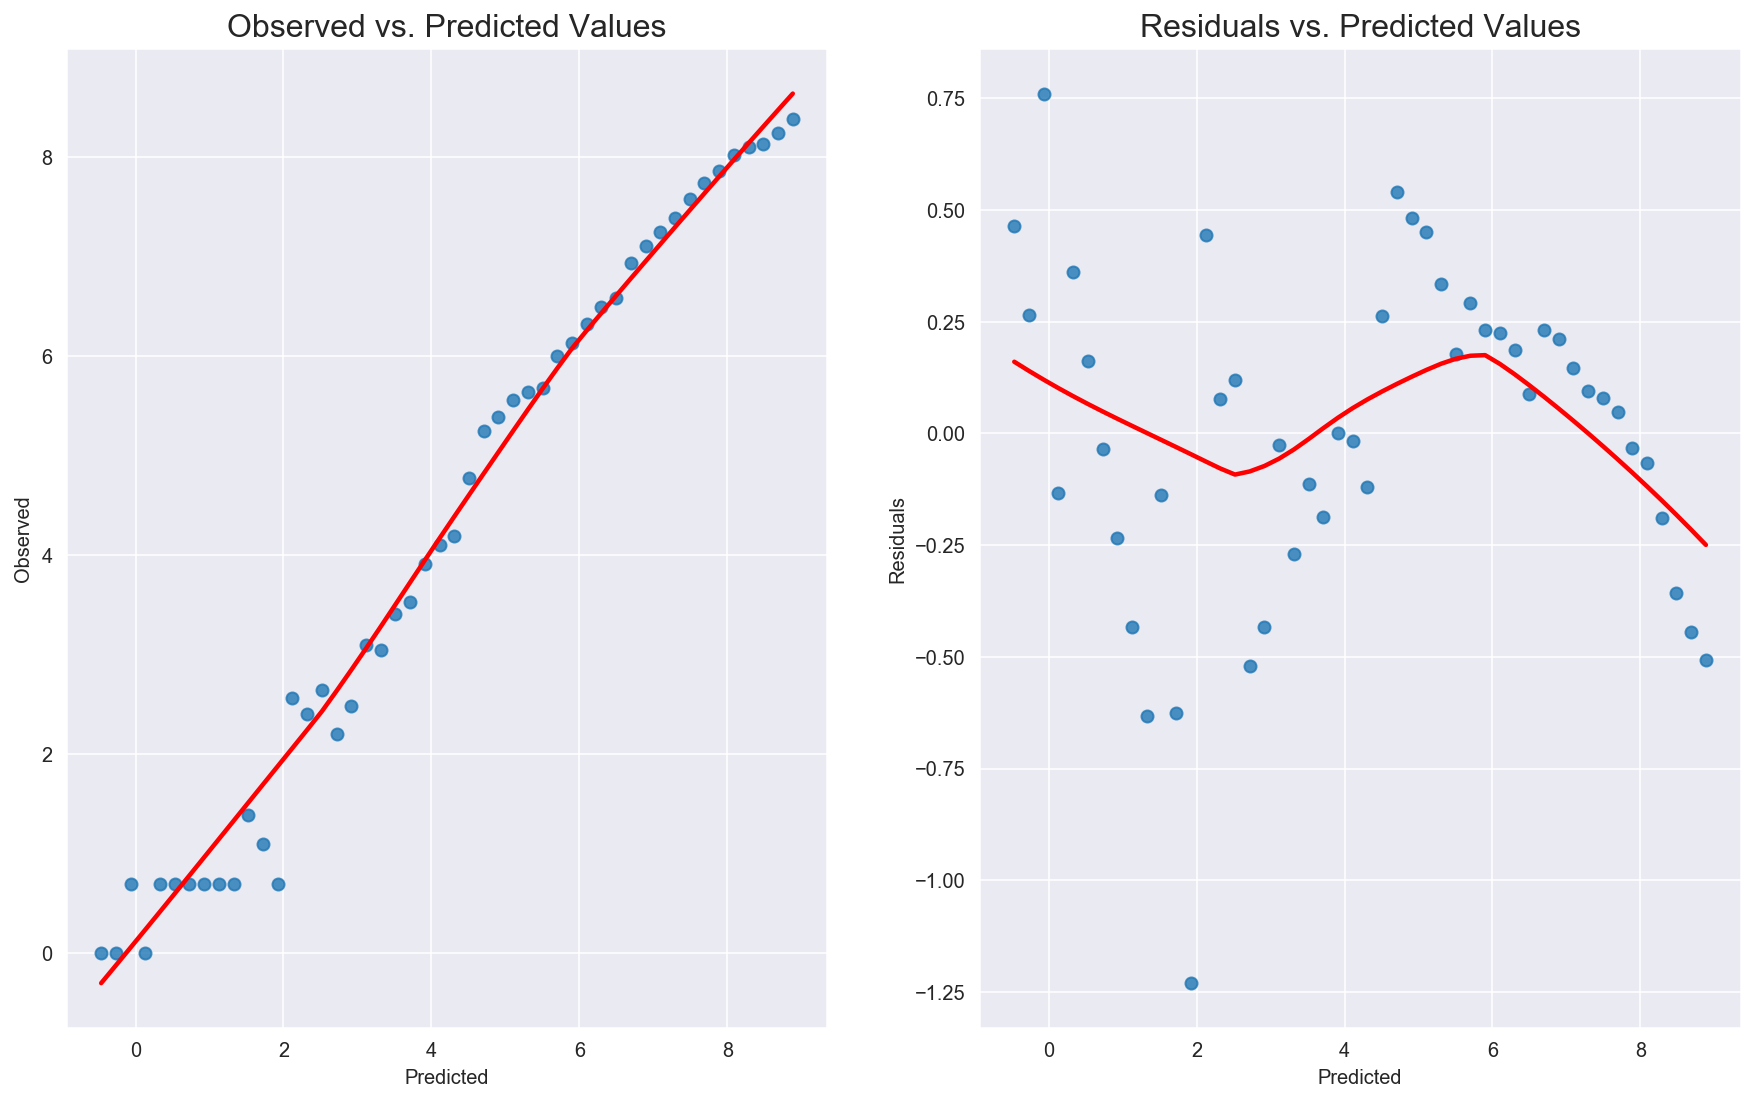

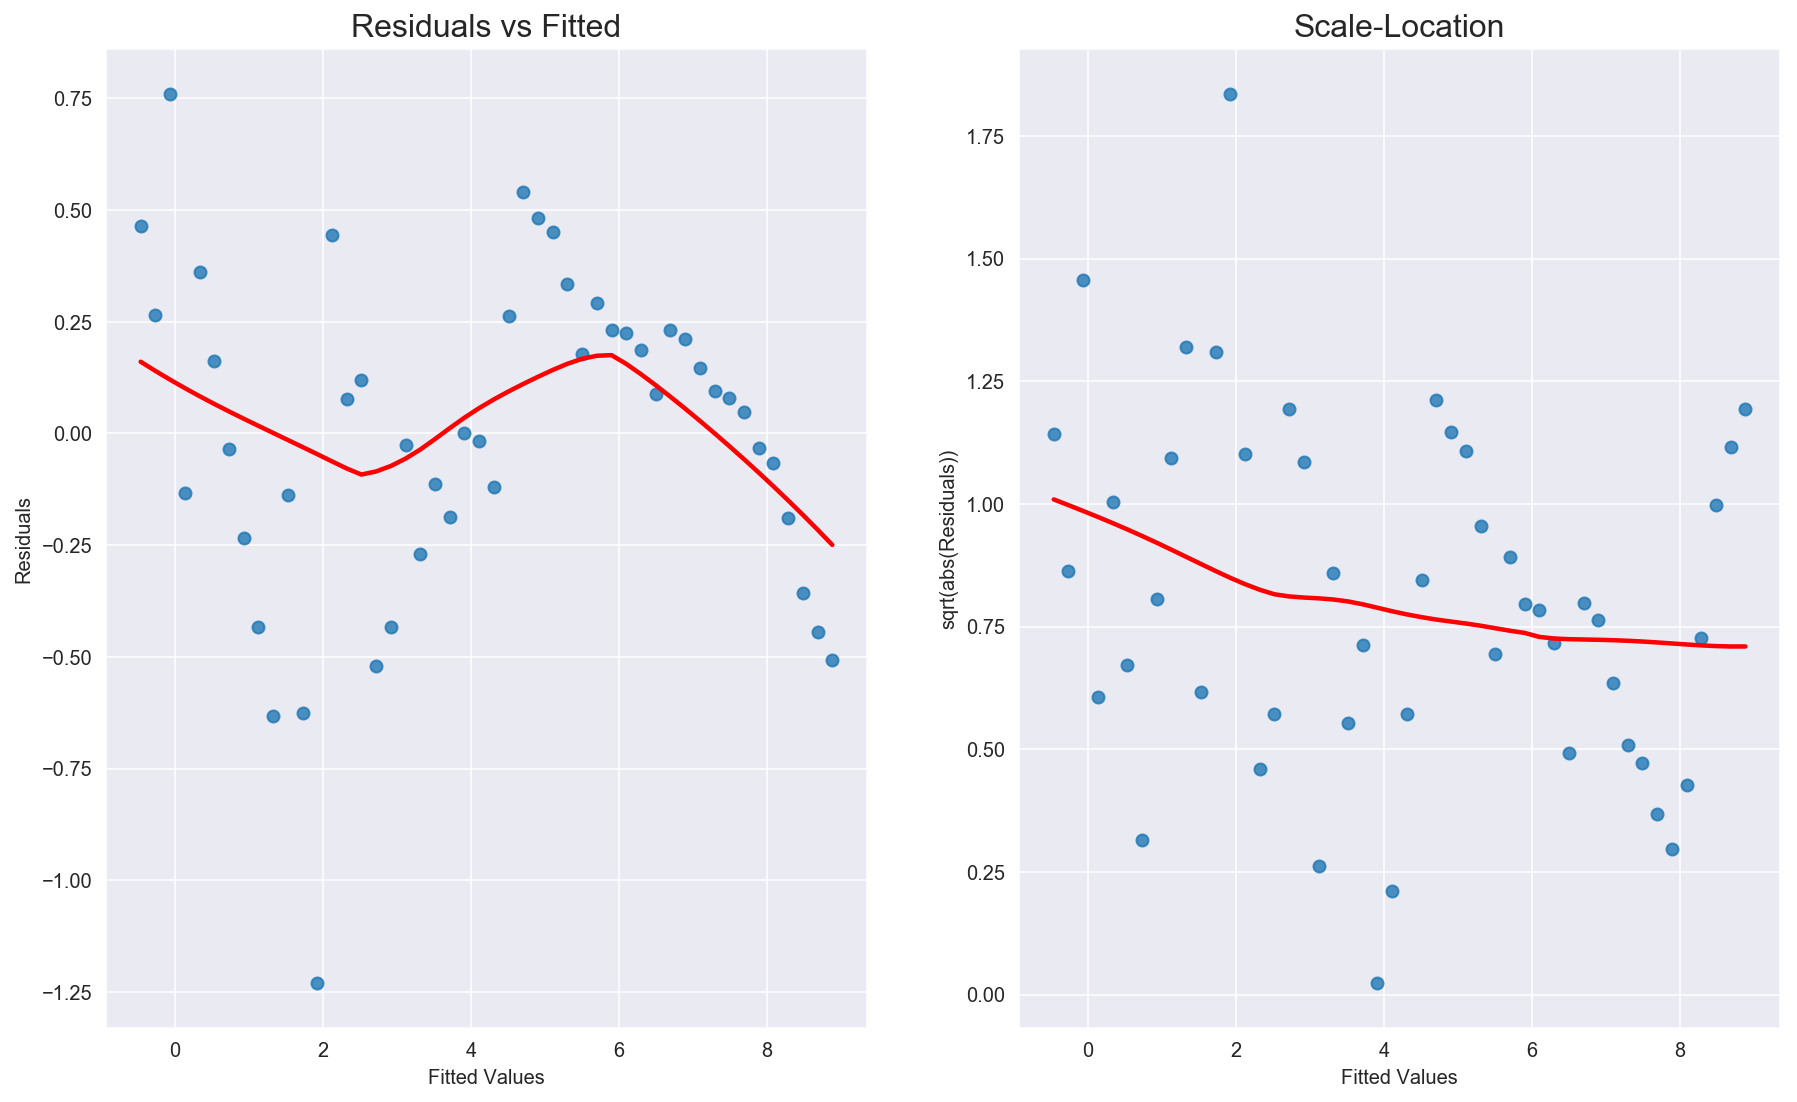

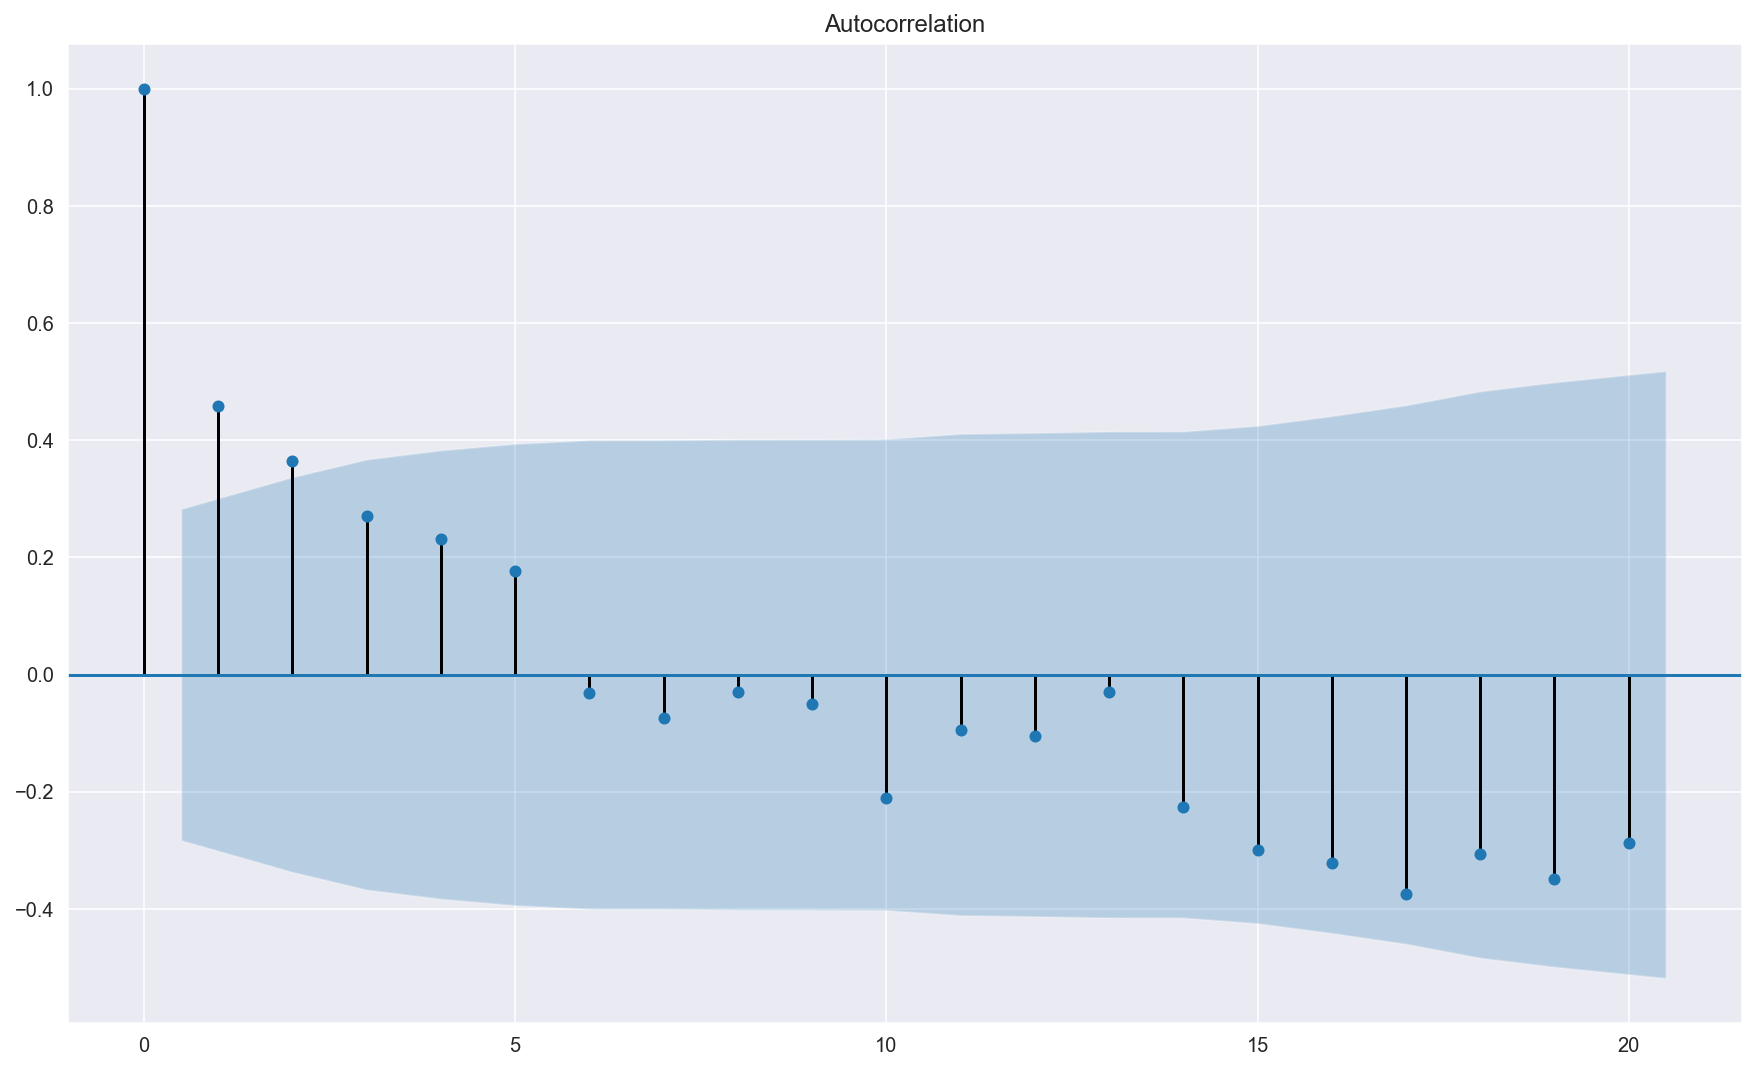

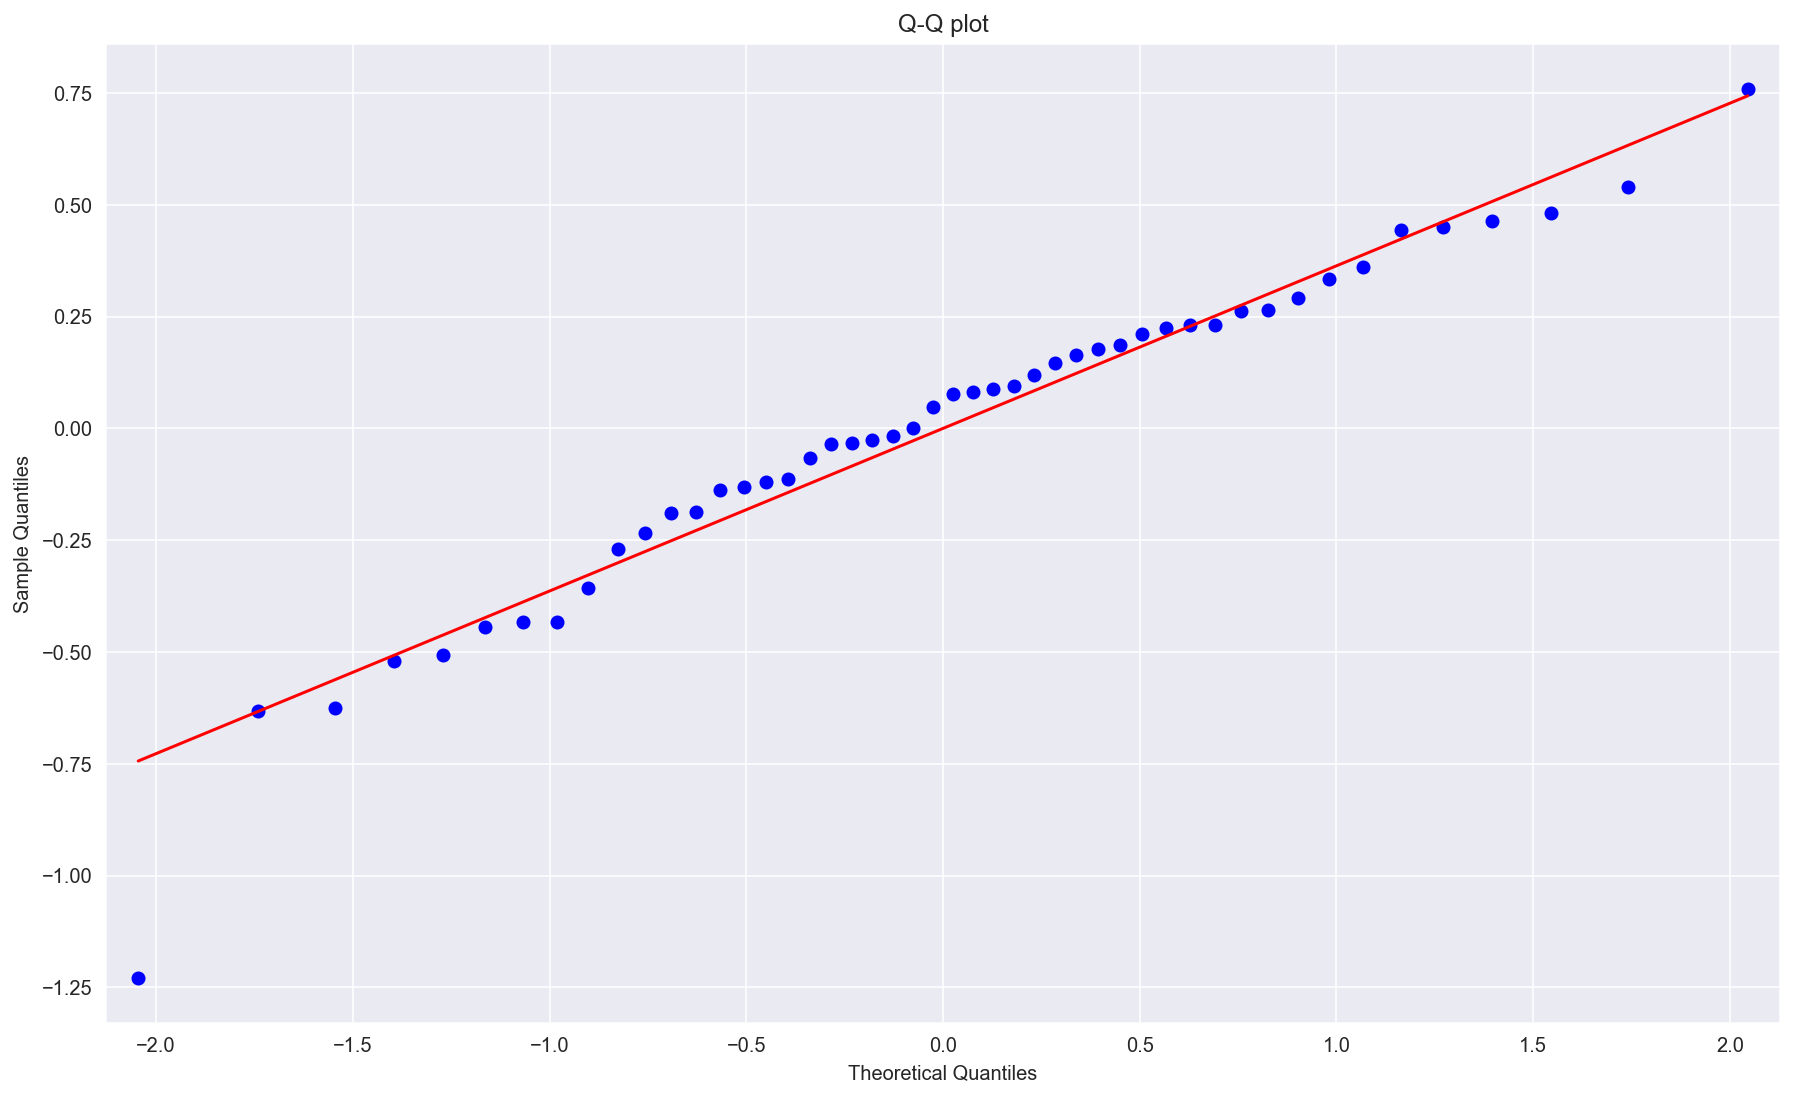

In [97]:
y_boxcox, lmbda = boxcox(temp["Recovered"].values + 1)
x = [[i] for i, d in enumerate(temp["Date"].dt.weekday)]
y = temp["Recovered"]
predict_log_r = gauss_marcov_hip(x[:48], np.log(y+1)[:48], "Recovered", 0)

## Box-cocx Recovered

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     2831.
Date:                Thu, 14 May 2020   Prob (F-statistic):           5.76e-43
Time:                        18:33:39   Log-Likelihood:                -24.976
No. Observations:                  48   AIC:                             53.95
Df Residuals:                      46   BIC:                             57.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7292      0.118     -6.169      0.0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



48


48


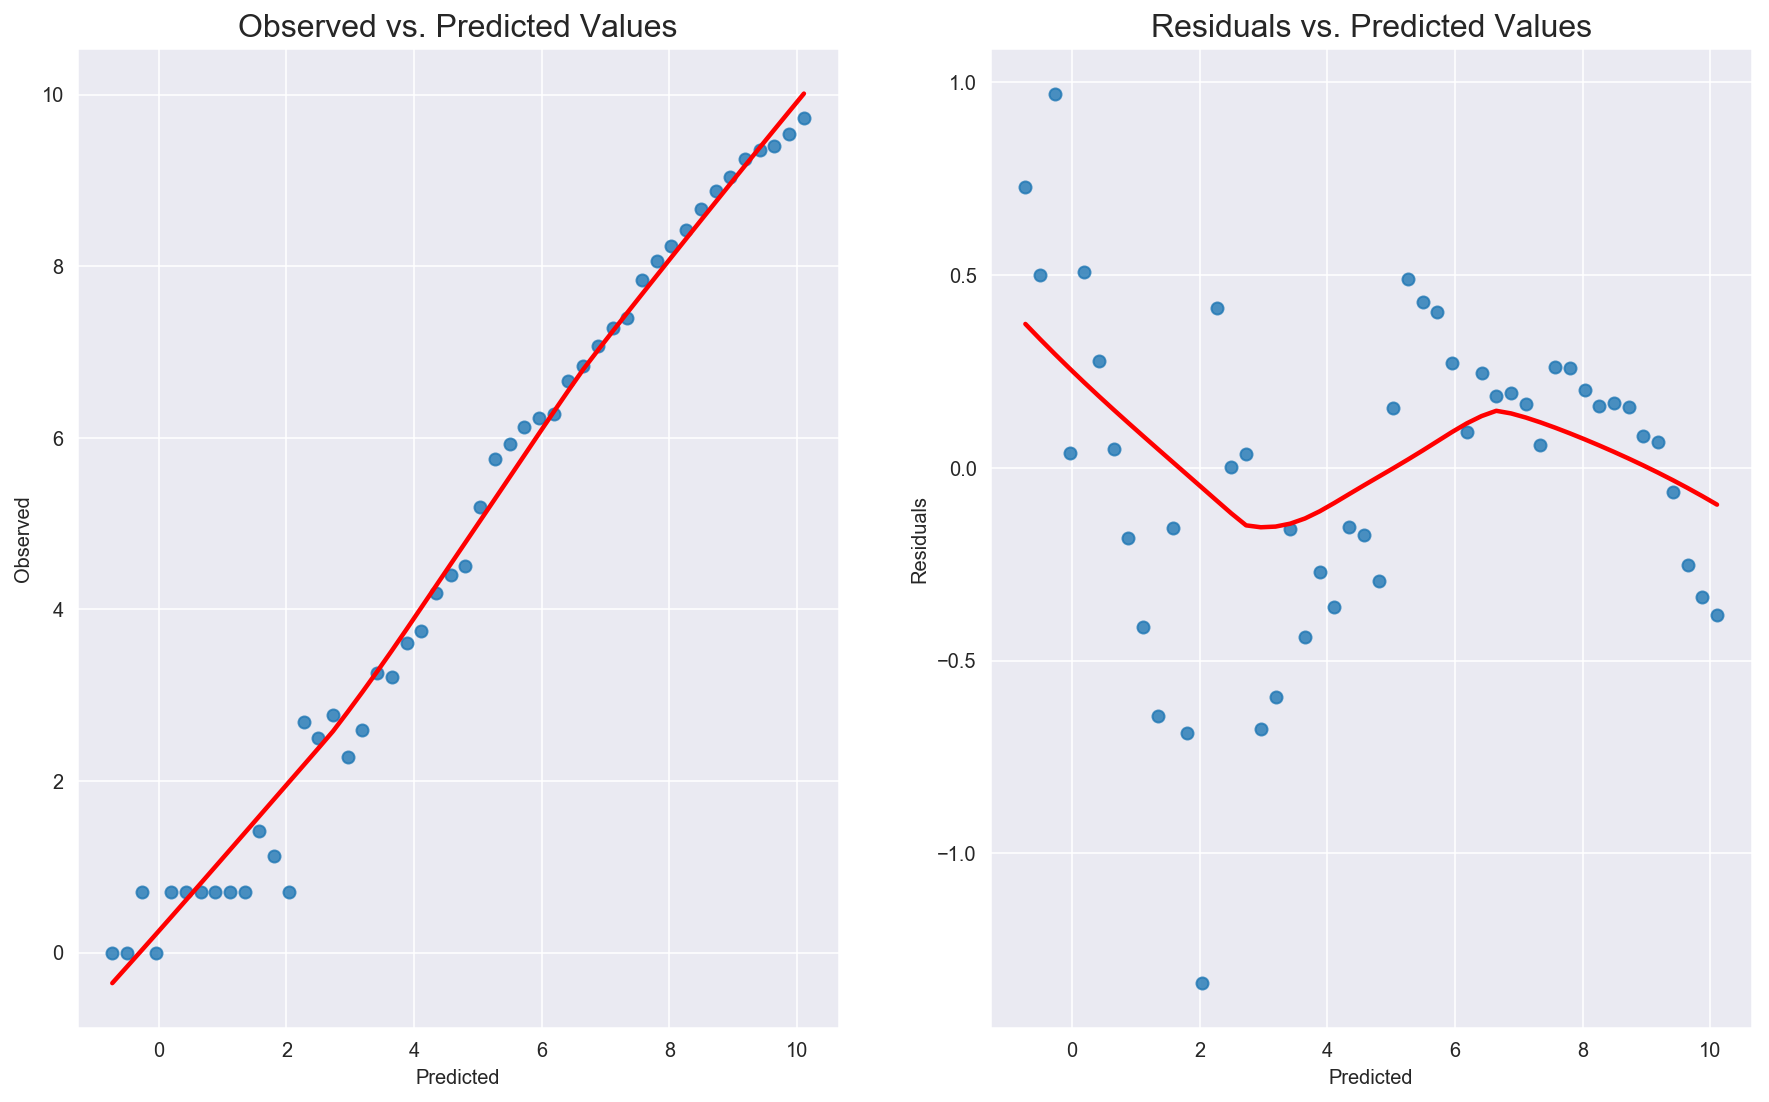

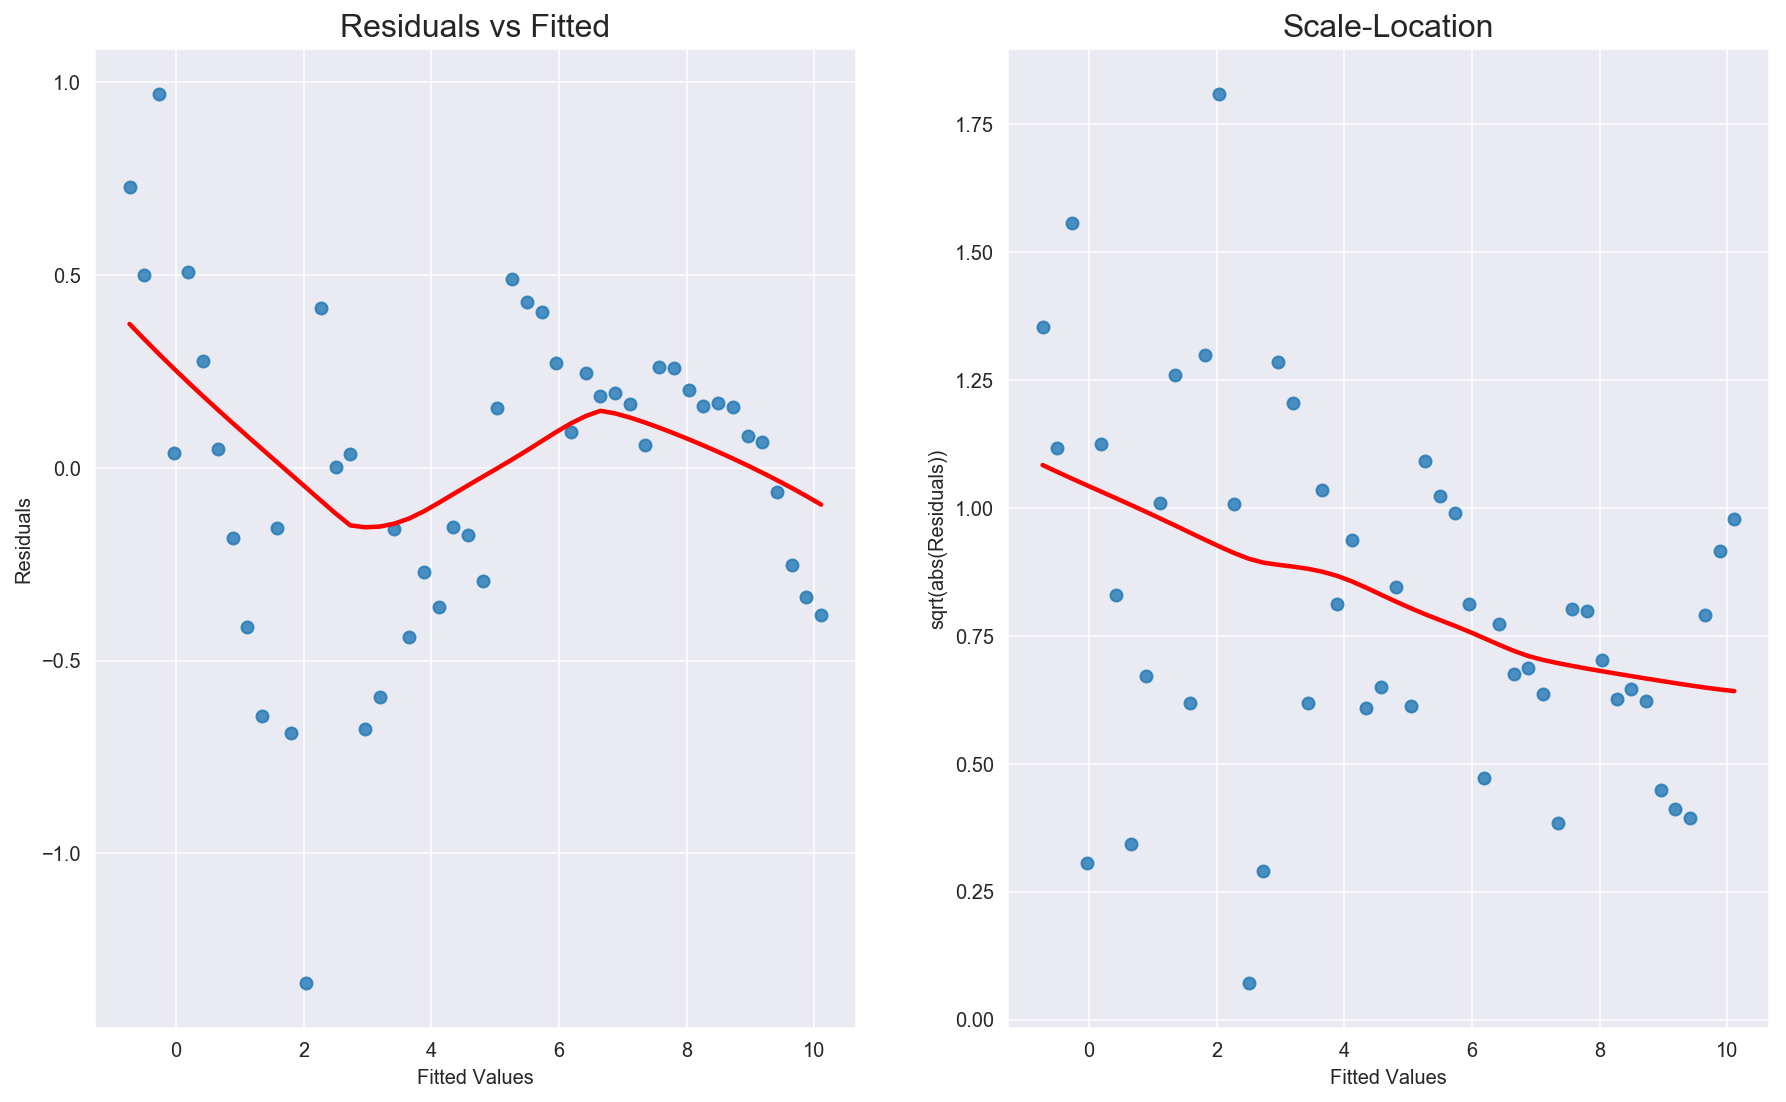

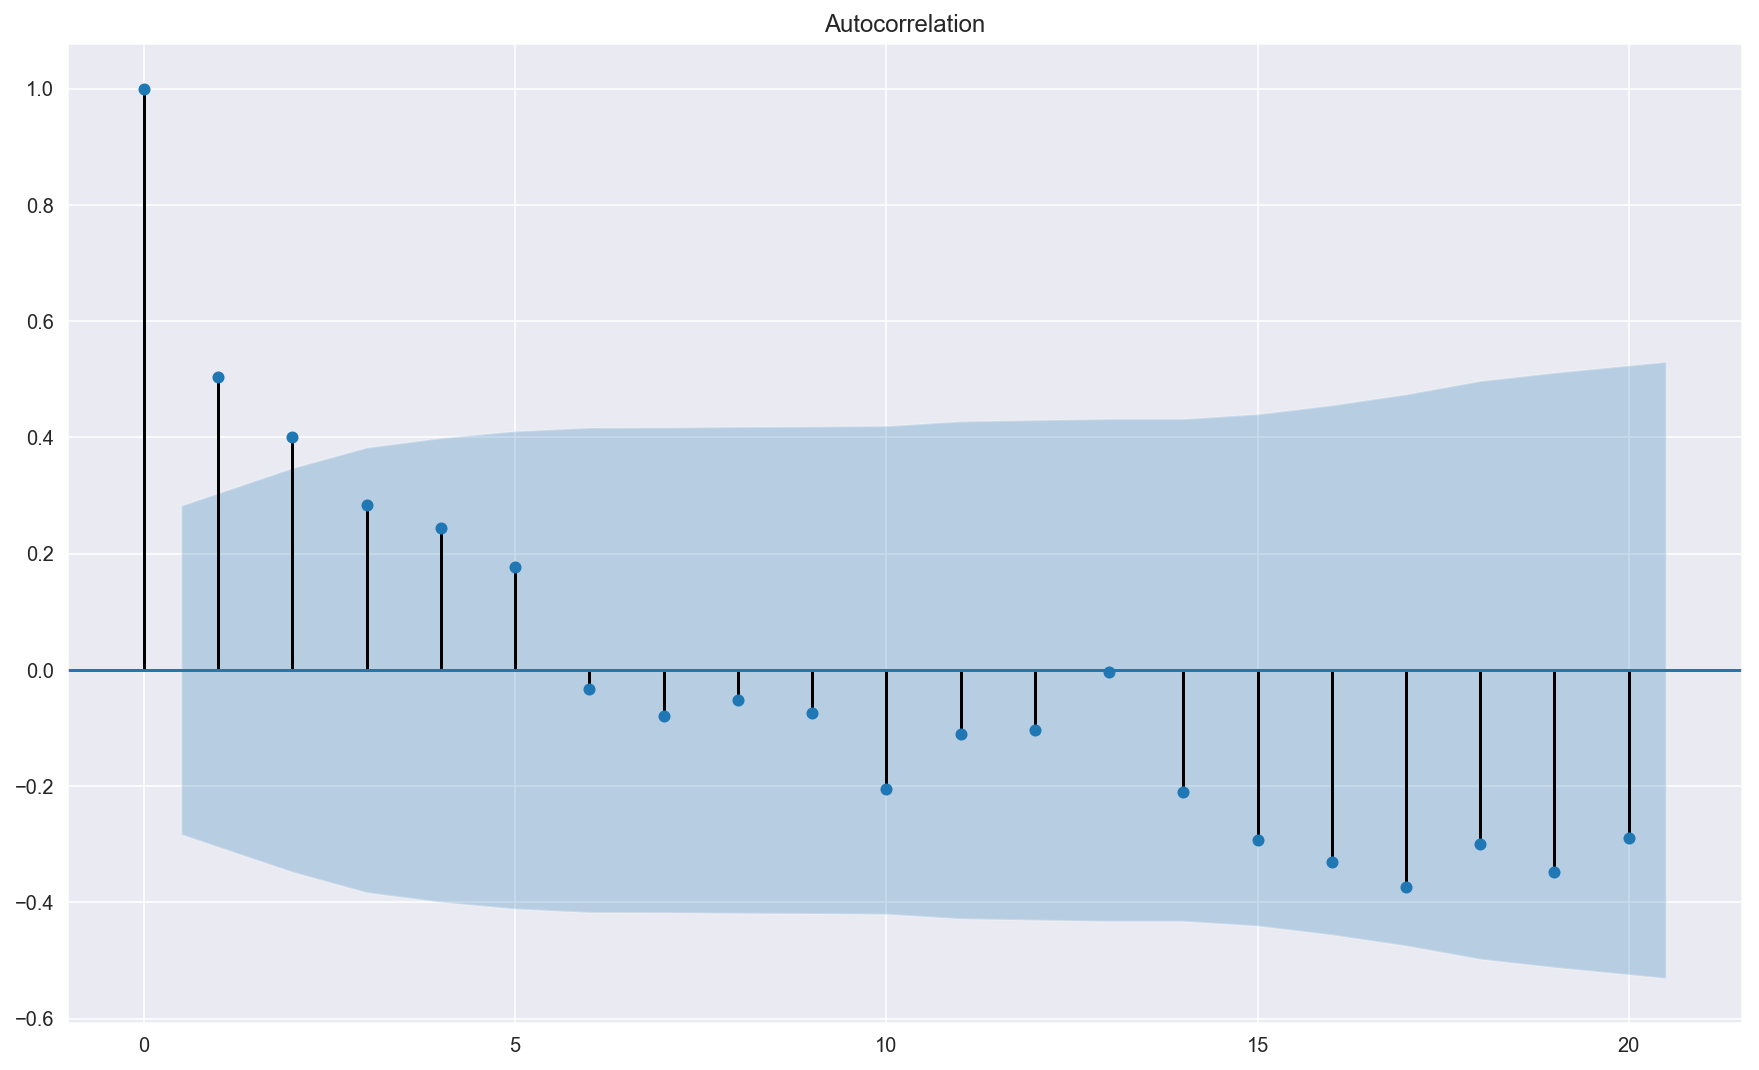

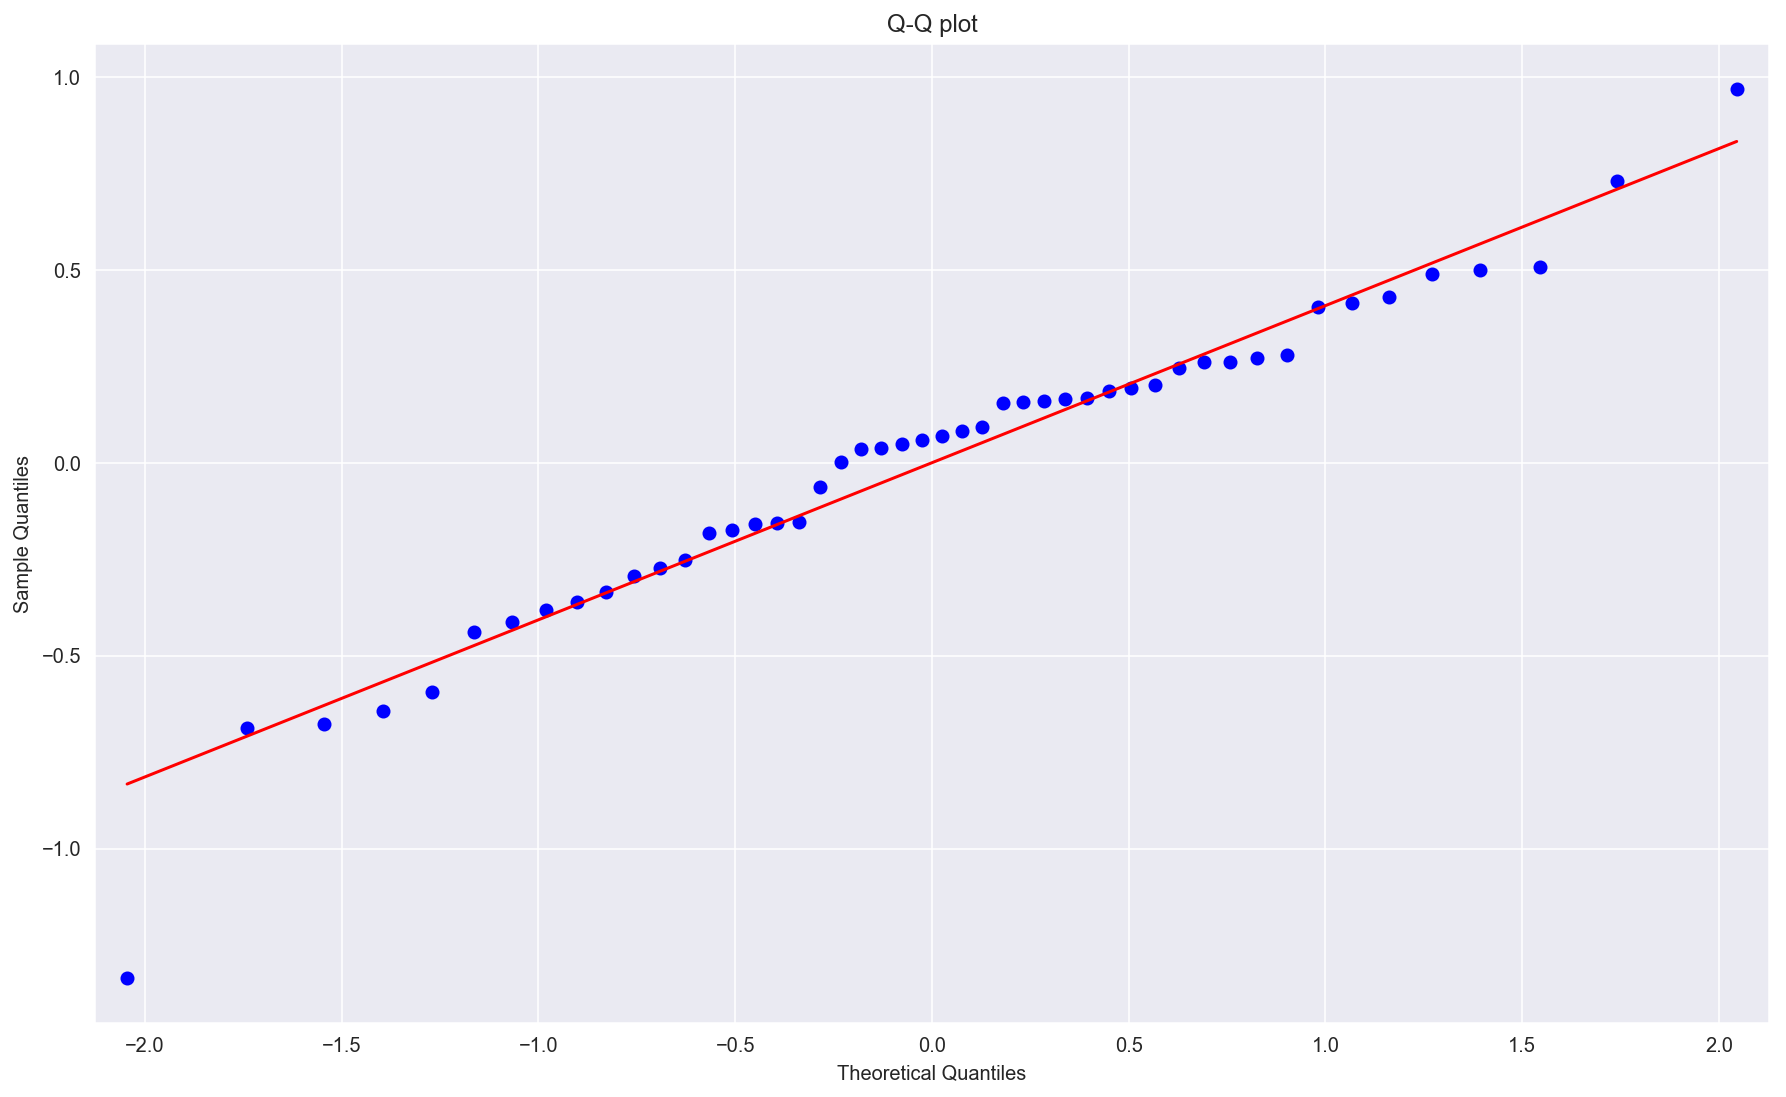

In [98]:
y_boxcox, lmbda = boxcox(temp["Recovered"].values + 1)
x = [[i] for i, d in enumerate(temp["Date"].dt.weekday)]
y = temp["Recovered"]
predict_box_r = gauss_marcov_hip(x[:48], y_boxcox[:48], "Recovered", lmbda)

# Предсказания SEIR модели и регрессий для Infected

In [69]:
seir_predict = []
with open("SEIR_predict.csv", "r") as rdr:
    for i in rdr:
        seir_predict.append(int(i))

In [100]:
predict_box = [int(i) for i in predict_box]
predict_log = [int(i) for i in predict_log]

In [128]:
d = {"date": temp["Date"],"SEIR": seir_predict[:53], "Regressor box-cocx": predict_box[:53], "Regressor log": predict_log[:53], "Russian": s}

In [131]:
pd.DataFrame(d)[40:]

,date,SEIR,Regressor box-cocx,Regressor log,Russian
43,2020-04-15,19396,22427,27628,21844.0
44,2020-04-16,23287,26054,34062,25344.0
45,2020-04-17,27457,30203,41995,29037.0
46,2020-04-18,31830,34941,51776,33399.0
47,2020-04-19,36334,40341,63835,39224.0
48,2020-04-20,40906,46484,78702,43058.0
49,2020-04-21,45492,53460,97031,47850.0
50,2020-04-22,50049,61370,119630,52572.0
51,2020-04-23,54545,70323,147492,57388.0
52,2020-04-24,58955,80440,181842,62438.0


# Проверка гипотиз

In [135]:
from scipy.stats import ttest_ind

In [136]:
iso = pd.read_csv(path + 'covid19-russia-regions-cases-14.05/isolation_daily.csv')
iso = iso[['Region', 'Date', 'Isol_idx', 'Isol_idx_minus_week', 'Region_geo_id']]
iso.columns = ['Region/City', 'Date', 'Isol_idx', 'Isol_idx_minus_week', 'Region_ID']
data = pd.read_csv(path + 'covid19-russia-regions-cases-14.05/covid19-russia-cases.csv')
iso.groupby(['Date', 'Region/City']).mean().index[0][0]
t = iso.groupby(['Date', 'Region/City']).mean()
newdf = pd.DataFrame(data = t[['Isol_idx', 'Isol_idx_minus_week']])
newdf = newdf.reset_index(drop=True)
newdf['Date'] = [t.index[i][0] for i in range(len(t))]
newdf['Region/City'] = [t.index[i][1] for i in range(len(t))]
df = pd.merge(data, newdf, left_on=['Date', 'Region/City'], right_on=['Date', 'Region/City'], how='inner')
 
df2 = df[df.Date >= '2020-04-02']
arr1 = []
for region in set(list(df2['Region/City'])):
    for i in range(len(df2[df2['Region/City'] == region]) // 7):
        arr1.append(df2[df2['Region/City'] == region][7*i:7*i+7:].mean().Isol_idx_minus_week)
arr2 = []
for region in set(list(df2['Region/City'])):
    for i in range(len(df2[df2['Region/City'] == region]) // 7):
        arr2.append(df2[df2['Region/City'] == region]['Confirmed'].pct_change()[7*i:7*i+7:].mean())
d = np.array(list(sorted(list(zip(arr1,arr2)))))
t = ttest_ind(d[:len(d)//2][:, 1], d[len(d)//2:][:, 1], equal_var = False)
print(t)
print('==========================')
print('Средние двух выборок:')
print(d[:len(d)//2][:, 1].mean())
print(d[len(d)//2:][:, 1].mean())

Ttest_indResult(statistic=-3.0307920642520223, pvalue=0.0026246739314218785)
Средние двух выборок:
0.14533268830011378
0.20722835114229116


In [137]:
vent = pd.read_csv(path + 'covid19-russia-regions-cases-14.05/regions-ventilators.csv')
df = pd.merge(data[data.Date == '2020-05-14'], vent, left_on=['Region/City'], right_on=['Region'], how='inner')
df['pr'] = df['Deaths'] / df['Confirmed']
arr3 = np.array(list(sorted(list(filter(lambda x: np.isfinite(x[0]) and np.isfinite(x[1]), list(zip(list(df.Vent_idx), list(df.pr))))))))
print(ttest_ind(arr3[:len(arr3)//2][:, 1], arr3[len(arr3)//2:][:, 1], equal_var = False))
print('==========================')
print('Средние двух выборок:')
print(arr3[:len(arr3)//2][:, 1].mean())
print(arr3[len(arr3)//2:][:, 1].mean())

Ttest_indResult(statistic=1.5520074153479069, pvalue=0.1268488944133191)
Средние двух выборок:
0.009845957377550138
0.007405346772983292
